In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import (classification_report, confusion_matrix, balanced_accuracy_score, 
accuracy_score, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go
import glob
import os


In [3]:
ROOT_DIR = "/kaggle/input/ferset" #MT Directory
DATASET_02 = ROOT_DIR + "/02_FER"
DATASET_02_TEST = DATASET_02+ "/test"
DATASET_02_TRAIN = DATASET_02+"/train"
KAGGLE_START = "/kaggle/input"
DATASET_01_TEST = KAGGLE_START + "/mri-test-set/test"
CNN_WEIGHTS_01 = KAGGLE_START + '/modelweights/MASTERS PROJECT WEIGHTS/MRI/'
CNN_WEIGHTS_02 = KAGGLE_START + '/modelweights/MASTERS PROJECT WEIGHTS/FER/'

CNN_NEW_WEIGHTS = KAGGLE_START+'/morecnnweights/untitled folder/'
CNN_MORE_W = KAGGLE_START+'/even-more-weights/Weights part 2/'
final_weight = KAGGLE_START+'/augdataweight/transfer_learning_model_resnet_50_model_2.h5'

# Things to wants:

ROC Curve
Curve of progress of accuracies

# MRI

## Test set loading

In [4]:
datagen = ImageDataGenerator()
image_size = (128, 128)
test_set_128 = datagen.flow_from_directory(DATASET_01_TEST, target_size=image_size, batch_size=32, class_mode='binary', shuffle=False)

image_size = (256,256)
test_set_256 = datagen.flow_from_directory(DATASET_01_TEST, target_size=image_size, batch_size=32, class_mode='binary', shuffle=False)


Found 121 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


## Testing Code Print

In [5]:
def weight_testing_CNN(model_v, weight_loc, test_set):
  #min_max_scaler = preprocessing.MinMaxScaler()


  model_v.load_weights(weight_loc)
  predictions = model_v.predict(test_set)
  #predict_final = np.where(predictions >=0, 1,0)
  predict_final = K.round(predictions)
  conf_mat = confusion_matrix(test_set.classes, predict_final)
  conf_mat_perc = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
  class_acc = conf_mat_perc.diagonal()
  target_names = ['Normal', 'Tumor']

  ConfusionMatrixDisplay.from_predictions(test_set.classes, predict_final, display_labels = target_names, normalize = 'true')
  print()
  print(f"Normal accuracy: {class_acc[0]}")
  print(f"Tumor accuracy: {class_acc[1]}")
  print()
  print(classification_report(test_set.classes, predict_final, target_names=target_names))
  print()
  w_acc = balanced_accuracy_score(test_set.classes, predict_final) 
  u_acc = accuracy_score(test_set.classes, predict_final)
  print(f'Unweighted Accuracy: {u_acc}')  
  print(f'Weighted Accuracy: {w_acc}')
  
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_set.classes, predictions)
  auc_keras = auc(fpr_keras, tpr_keras)
  #print(auc_keras)
  return fpr_keras, tpr_keras, auc_keras, u_acc, w_acc

In [6]:
def weight_testing_TL(model_v, weight_loc, test_set):
  #min_max_scaler = preprocessing.MinMaxScaler()


  model_v.load_weights(weight_loc)
  predictions = model_v.predict(test_set)
  predict_final = np.where(predictions >=0, 1,0)
  #predict_final = K.round(predictions)
  conf_mat = confusion_matrix(test_set.classes, predict_final)
  conf_mat_perc = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
  class_acc = conf_mat_perc.diagonal()
  target_names = ['Normal', 'Tumor']
  ConfusionMatrixDisplay.from_predictions(test_set.classes, predict_final, display_labels = target_names, normalize = 'true')
  print()
  print(f"Normal accuracy: {class_acc[0]}")
  print(f"Tumor accuracy: {class_acc[1]}")
  print()
  print(classification_report(test_set.classes, predict_final, target_names=target_names))
  print()
  w_acc = balanced_accuracy_score(test_set.classes, predict_final) 
  u_acc = accuracy_score(test_set.classes, predict_final)
  print(f'Unweighted Accuracy: {u_acc}')  
  print(f'Weighted Accuracy: {w_acc}')
  
    
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_set.classes, predictions)
  auc_keras = auc(fpr_keras, tpr_keras)
  #print(auc_keras)
  return fpr_keras, tpr_keras, auc_keras, u_acc, w_acc

## Experiment 1


In [7]:
# Weights:  create_model_V2/AugTest/30epochs/create_model_V2_model_4.h5

def create_model_V2():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  #model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

model_2 = create_model_V2()
model_2.summary()

2022-05-10 20:11:12.939245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

2022-05-10 20:11:13.057735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 20:11:13.058578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 20:11:13.059750: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 20:11:13.060045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

2022-05-10 20:11:16.465437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-10 20:11:17.621369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Normal accuracy: 0.6153846153846154
Tumor accuracy: 0.5652173913043478

              precision    recall  f1-score   support

      Normal       0.52      0.62      0.56        52
       Tumor       0.66      0.57      0.61        69

    accuracy                           0.59       121
   macro avg       0.59      0.59      0.59       121
weighted avg       0.60      0.59      0.59       121


Unweighted Accuracy: 0.5867768595041323
Weighted Accuracy: 0.5903010033444815


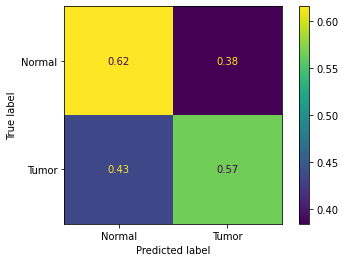

In [8]:
fpr_e1, tpr_e1, auc_e1, uacc_e1, wacc_e1 = weight_testing_CNN(model_2, CNN_WEIGHTS_01+'/create_model_V2_model_4.h5', test_set_128)

## Experiment 2

In [9]:
#Weights associated: create_model_V7_model_2.h5
def create_model_V7():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  #model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model
model_7 = create_model_V7()
model_7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)      


Normal accuracy: 0.3076923076923077
Tumor accuracy: 0.8985507246376812

              precision    recall  f1-score   support

      Normal       0.70      0.31      0.43        52
       Tumor       0.63      0.90      0.74        69

    accuracy                           0.64       121
   macro avg       0.66      0.60      0.58       121
weighted avg       0.66      0.64      0.61       121


Unweighted Accuracy: 0.6446280991735537
Weighted Accuracy: 0.6031215161649944


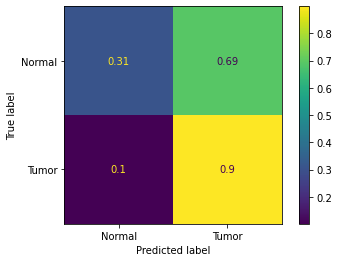

In [10]:
fpr_e1, tpr_e1, auc_e1, uacc_e1, wacc_e1 = weight_testing_CNN(model_7, CNN_WEIGHTS_01+'create_model_V7_model_2.h5', test_set_128)

## Experiment 3

In [11]:
#Weights: create_model_V3_model_1.h5

def create_model_V3():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  #model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  #model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model
model_3 = create_model_V3()
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)      


Normal accuracy: 0.8076923076923077
Tumor accuracy: 0.8405797101449275

              precision    recall  f1-score   support

      Normal       0.79      0.81      0.80        52
       Tumor       0.85      0.84      0.85        69

    accuracy                           0.83       121
   macro avg       0.82      0.82      0.82       121
weighted avg       0.83      0.83      0.83       121


Unweighted Accuracy: 0.8264462809917356
Weighted Accuracy: 0.8241360089186176


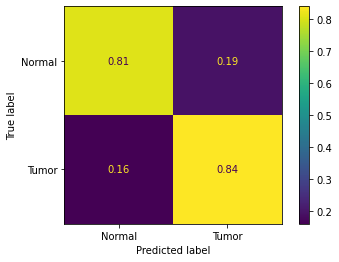

In [12]:
fpr_e2, tpr_e2, auc_e2, uacc_e2, wacc_e2 = weight_testing_CNN(model_3, CNN_WEIGHTS_01+'create_model_V3_model_1.h5', test_set_128)

## Experiment 4


In [13]:
# Weights: transfer_learning_model_dense169_2/30epochs/transfer_learning_model_dense169_2_model_2.h5

def transfer_learning_model_dense169_2():

  IMG_SHAPE = (256,256,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = tf.keras.applications.densenet.preprocess_input(inputs)
  base_model = tf.keras.applications.densenet.DenseNet169(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
  #print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 400
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  prediction_layer = tf.keras.layers.Dense(1)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_dense169_2 = transfer_learning_model_dense169_2()
transfer_model_dense169_2.summary()

51888128/51877672 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
______________________________________________________________


Normal accuracy: 0.8653846153846154
Tumor accuracy: 1.0

              precision    recall  f1-score   support

      Normal       1.00      0.87      0.93        52
       Tumor       0.91      1.00      0.95        69

    accuracy                           0.94       121
   macro avg       0.95      0.93      0.94       121
weighted avg       0.95      0.94      0.94       121


Unweighted Accuracy: 0.9421487603305785
Weighted Accuracy: 0.9326923076923077


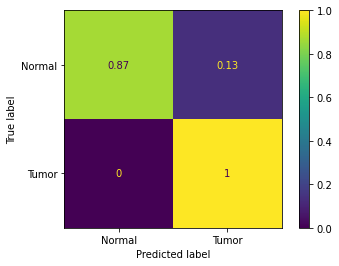

In [14]:
fpr_e3, tpr_e3, auc_e3, uacc_e3, wacc_e3 = weight_testing_TL(transfer_model_dense169_2, CNN_WEIGHTS_01+'transfer_learning_model_dense169_2_model_2.h5', test_set_256)

In [15]:
## Dense 400

In [16]:
## dense 3000

In [17]:
def transfer_learning_model_dense169_300():

  IMG_SHAPE = (256,256,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = tf.keras.applications.densenet.preprocess_input(inputs)
  base_model = tf.keras.applications.densenet.DenseNet169(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 300
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  prediction_layer = tf.keras.layers.Dense(1)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

dense_300 = transfer_learning_model_dense169_300()
dense_300.summary()


595
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1664)              


Normal accuracy: 0.0
Tumor accuracy: 1.0

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        52
       Tumor       0.57      1.00      0.73        69

    accuracy                           0.57       121
   macro avg       0.29      0.50      0.36       121
weighted avg       0.33      0.57      0.41       121


Unweighted Accuracy: 0.5702479338842975
Weighted Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


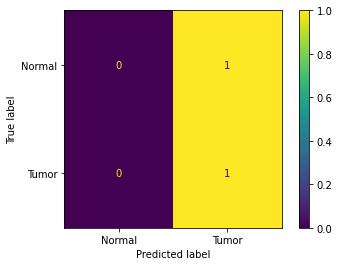

In [18]:
fpr_ez, tpr_ez, auc_ez, uacc_ed300, wacc_ed300 = weight_testing_TL(dense_300, CNN_MORE_W+'Dense_300.h5', test_set_256)

In [19]:
## Dense 450
def transfer_learning_model_dense169_450():

  IMG_SHAPE = (256,256,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = tf.keras.applications.densenet.preprocess_input(inputs)
  base_model = tf.keras.applications.densenet.DenseNet169(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
  #print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 450
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  prediction_layer = tf.keras.layers.Dense(1)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

dense_450 = transfer_learning_model_dense169_450()
dense_450.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1664)              0   

2022-05-10 20:11:53.041088: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /kaggle/input/even-more-weights/Weights part 2/dense_450l: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?



Normal accuracy: 0.057692307692307696
Tumor accuracy: 1.0

              precision    recall  f1-score   support

      Normal       1.00      0.06      0.11        52
       Tumor       0.58      1.00      0.74        69

    accuracy                           0.60       121
   macro avg       0.79      0.53      0.42       121
weighted avg       0.76      0.60      0.47       121


Unweighted Accuracy: 0.5950413223140496
Weighted Accuracy: 0.5288461538461539


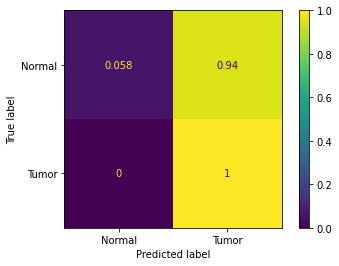

In [20]:
fpr_ez, tpr_ez, auc_ez, uacc_ed450, wacc_ed450 = weight_testing_TL(dense_450, CNN_MORE_W+'dense_450l', test_set_256)

## Experiment 5


Normal accuracy: 0.9230769230769231
Tumor accuracy: 1.0

              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96        52
       Tumor       0.95      1.00      0.97        69

    accuracy                           0.97       121
   macro avg       0.97      0.96      0.97       121
weighted avg       0.97      0.97      0.97       121


Unweighted Accuracy: 0.9669421487603306
Weighted Accuracy: 0.9615384615384616


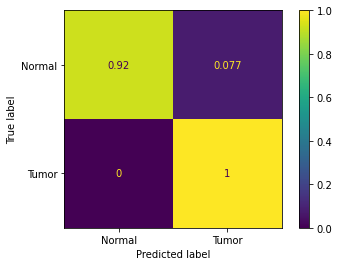

In [21]:
# Weights, same model as before transfer_learning_model_dense169_2/AugTest/30epochs/transfer_learning_model_dense169_2_model_2.h5
transfer_model_dense169_3 = transfer_learning_model_dense169_2()
fpr_e4, tpr_e4, auc_e4, uacc_e4, wacc_e4 = weight_testing_TL(transfer_model_dense169_3, CNN_WEIGHTS_01+'transfer_learning_model_dense169_2_model_2 (1).h5', test_set_256)

In [22]:
roc_fig = go.Figure()
#roc_fig.add_trace(go.Scatter(x=fpr_e1, y=tpr_e1, name=f"ROC E1 (AUC={auc_e1:.4f})", mode='lines'))
roc_fig.add_trace(go.Scatter(x=fpr_e2, y=tpr_e2, name=f"ROC E1 (AUC={auc_e2:.4f})", mode='lines'))
roc_fig.add_trace(go.Scatter(x=fpr_e3, y=tpr_e3, name=f"ROC E2 (AUC={auc_e3:.4f})", mode='lines'))
roc_fig.add_trace(go.Scatter(x=fpr_e4, y=tpr_e4, name=f"ROC E3 (AUC={auc_e4:.4f})", mode='lines'))
roc_fig.update_layout(
    title = 'ROC Curve of Different Experiments',
    title_x = 0.5,
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)
roc_fig.show()


In [23]:
x = ['Initial CNN (E1)','DenseNet169 TL (E2)','Data Augmentation (E3)']
y1 = [uacc_e2,uacc_e3,uacc_e4]
y2 = [wacc_e2,wacc_e3,wacc_e4]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y1, name="Accuracy", mode='lines+markers'))
#fig.add_trace(go.Scatter(x=x, y=y2, name="Weighted Accuracy", mode='lines+markers'))

fig.update_layout(
    title = 'Experiment Accuracy Progress',
    title_x = 0.5,
    xaxis_title='Experiment',
    yaxis_title='Accuracy',
)
fig.update_xaxes(tickangle=45)
fig.show()


# FER DATASET

In [24]:
image_size = (48, 48)
colormode = 'rgb'

test_set_48 = datagen.flow_from_directory(DATASET_02_TEST, target_size=image_size, color_mode =colormode, batch_size=32, shuffle=False)

image_size = (224, 224)
test_set_224 = datagen.flow_from_directory(DATASET_02_TEST, target_size=image_size, color_mode =colormode, batch_size=32, shuffle=False)



Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [25]:
my_list = os.listdir(DATASET_02_TEST)
print(my_list)

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [26]:
def weight_testing_FER(model_v, weight_loc, test_set):
  #min_max_scaler = preprocessing.MinMaxScaler()

  fig, ax = plt.subplots(figsize=(13, 13))
  plt.rcParams['font.size'] = '13'

  model_v.load_weights(weight_loc)
  predictions = model_v.predict(test_set)
  #predict_final = np.where(predictions >=0, 1,0)
  predict_final = tf.argmax(predictions, axis=-1)
  conf_mat = confusion_matrix(test_set.classes, predict_final)
  conf_mat_perc = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
  class_acc = conf_mat_perc.diagonal()
  ConfusionMatrixDisplay.from_predictions(test_set.classes, predict_final, display_labels = my_list, normalize = 'true', ax=ax)
  print()
  for i in range(len(my_list)):
      print(f'{my_list[i].capitalize()} accuracy: {class_acc[i]}')
  print()
  print(classification_report(test_set.classes, predict_final, target_names=my_list))
  w_acc = balanced_accuracy_score(test_set.classes, predict_final) 
  u_acc = accuracy_score(test_set.classes, predict_final)
  print(f'Unweighted Accuracy: {u_acc}')  
  print(f'Weighted Accuracy: {w_acc}')
    
  macro_roc_auc_ovr = roc_auc_score(test_set.classes, predictions, multi_class="ovr", average="macro")

  #fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_set.classes, predictions)
  #auc_keras = auc(fpr_keras, tpr_keras)
  #print(auc_keras)
  return macro_roc_auc_ovr, u_acc, w_acc

## Experiment 1


In [27]:
def create_model_VF():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(7, activation='softmax'))
    
    return model
model_VF = create_model_VF()


Surprise accuracy: 0.47286012526096033
Fear accuracy: 0.43243243243243246
Angry accuracy: 0.322265625
Neutral accuracy: 0.7209695603156708
Sad accuracy: 0.5150040551500406
Disgust accuracy: 0.4723336006415397
Happy accuracy: 0.6823104693140795

              precision    recall  f1-score   support

    surprise       0.42      0.47      0.45       958
        fear       0.68      0.43      0.53       111
       angry       0.46      0.32      0.38      1024
     neutral       0.73      0.72      0.73      1774
         sad       0.46      0.52      0.49      1233
     disgust       0.41      0.47      0.44      1247
       happy       0.72      0.68      0.70       831

    accuracy                           0.54      7178
   macro avg       0.56      0.52      0.53      7178
weighted avg       0.55      0.54      0.54      7178

Unweighted Accuracy: 0.5434661465589301
Weighted Accuracy: 0.5168822668735318


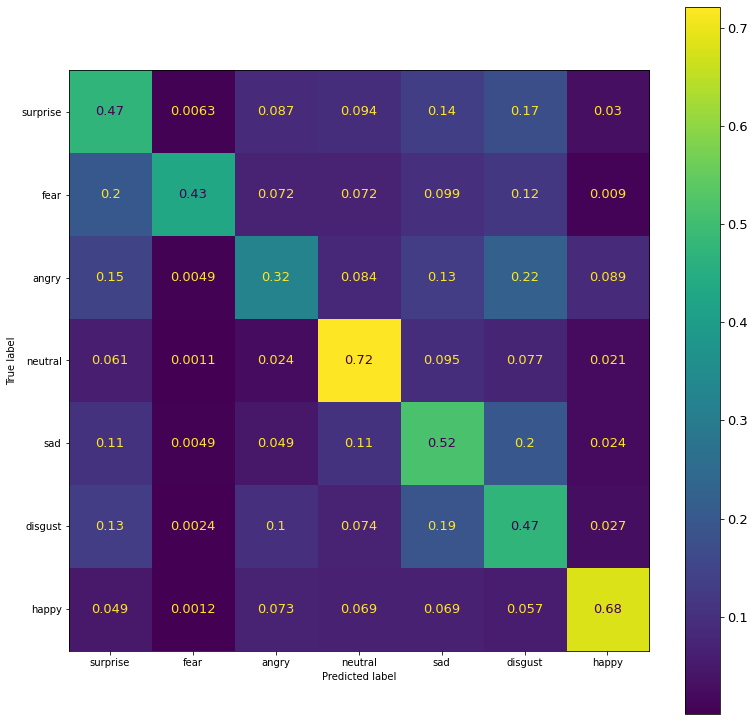

In [28]:
auc_fer_e1, uacc_fer_e1, wacc_fer_e1 = weight_testing_FER(model_VF, CNN_NEW_WEIGHTS+'FirstCnn/create_model_VF_model_4.h5', test_set_48)


Surprise accuracy: 0.42484342379958245
Fear accuracy: 0.36936936936936937
Angry accuracy: 0.3994140625
Neutral accuracy: 0.7502818489289741
Sad accuracy: 0.49716139497161393
Disgust accuracy: 0.4450681635926223
Happy accuracy: 0.6618531889290012

              precision    recall  f1-score   support

    surprise       0.47      0.42      0.44       958
        fear       0.66      0.37      0.47       111
       angry       0.39      0.40      0.39      1024
     neutral       0.72      0.75      0.74      1774
         sad       0.50      0.50      0.50      1233
     disgust       0.41      0.45      0.43      1247
       happy       0.73      0.66      0.69       831

    accuracy                           0.54      7178
   macro avg       0.55      0.51      0.52      7178
weighted avg       0.55      0.54      0.54      7178

Unweighted Accuracy: 0.5441627194204514
Weighted Accuracy: 0.506855921727309


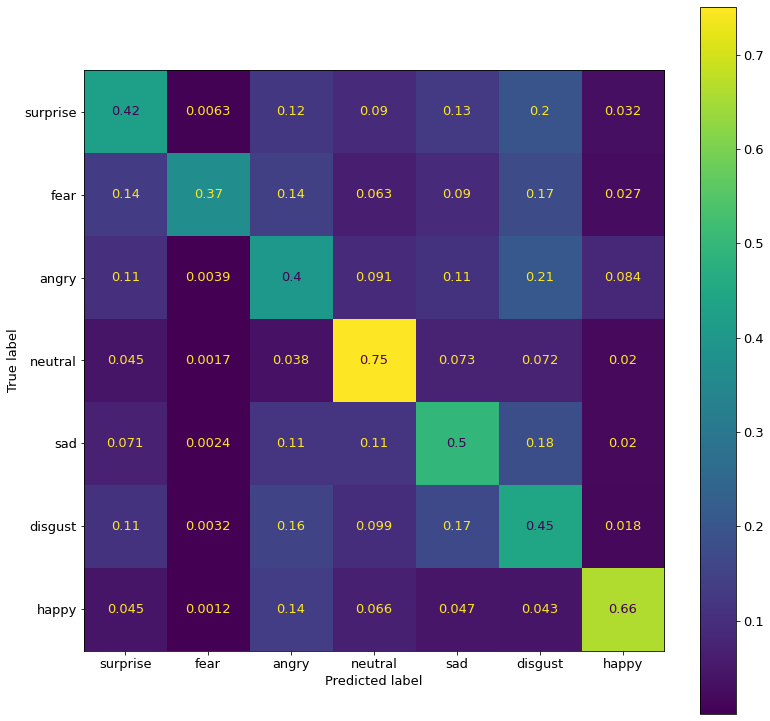

In [29]:
#no weight
auc_fer_e1, uacc_fer_e1, wacc_fer_e1 = weight_testing_FER(model_VF, CNN_MORE_W+'0dropout_noweight.h5', test_set_48)

In [30]:
def create_model_VF_04():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(7, activation='softmax'))
    
    return model

model_VF_04 = create_model_VF_04()


Surprise accuracy: 0.4175365344467641
Fear accuracy: 0.1981981981981982
Angry accuracy: 0.1640625
Neutral accuracy: 0.6916572717023676
Sad accuracy: 0.3446877534468775
Disgust accuracy: 0.8267842822774659
Happy accuracy: 0.6498194945848376

              precision    recall  f1-score   support

    surprise       0.51      0.42      0.46       958
        fear       0.56      0.20      0.29       111
       angry       0.50      0.16      0.25      1024
     neutral       0.84      0.69      0.76      1774
         sad       0.56      0.34      0.43      1233
     disgust       0.34      0.83      0.48      1247
       happy       0.73      0.65      0.69       831

    accuracy                           0.53      7178
   macro avg       0.58      0.47      0.48      7178
weighted avg       0.60      0.53      0.52      7178

Unweighted Accuracy: 0.5312064641961549
Weighted Accuracy: 0.4703922906652158


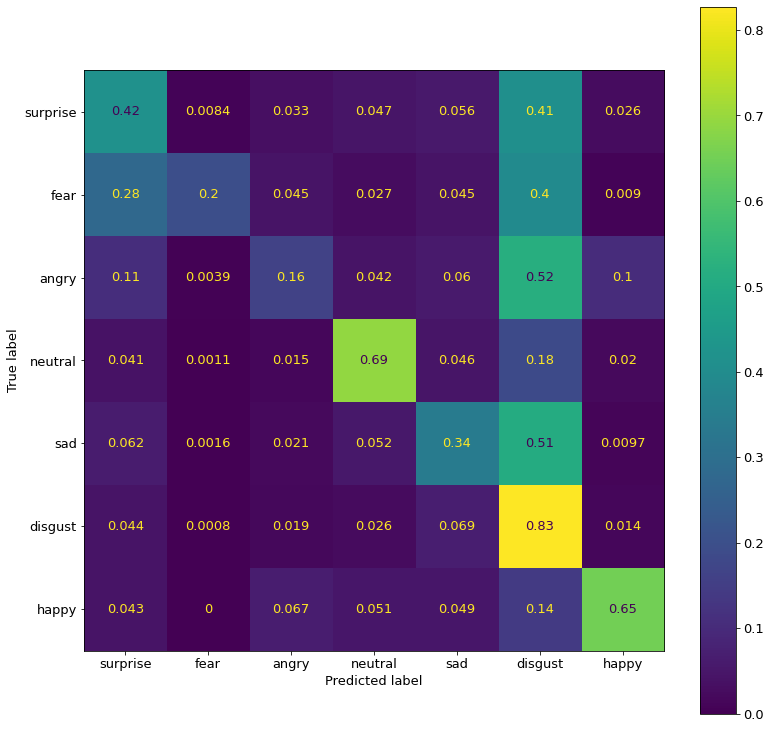

In [31]:
auc_fer_ez, uacc_fer_ez, wacc_fer_ez = weight_testing_FER(model_VF_04, CNN_NEW_WEIGHTS+'FirstCnn/create_model_VF_02_model_2.h5', test_set_48)


Surprise accuracy: 0.5177453027139874
Fear accuracy: 0.5225225225225225
Angry accuracy: 0.27734375
Neutral accuracy: 0.822435174746336
Sad accuracy: 0.6180048661800487
Disgust accuracy: 0.3664795509222133
Happy accuracy: 0.7845968712394705

              precision    recall  f1-score   support

    surprise       0.48      0.52      0.50       958
        fear       0.57      0.52      0.55       111
       angry       0.48      0.28      0.35      1024
     neutral       0.76      0.82      0.79      1774
         sad       0.48      0.62      0.54      1233
     disgust       0.48      0.37      0.41      1247
       happy       0.67      0.78      0.72       831

    accuracy                           0.58      7178
   macro avg       0.56      0.56      0.55      7178
weighted avg       0.57      0.58      0.57      7178

Unweighted Accuracy: 0.5806631373641683
Weighted Accuracy: 0.5584468626177969


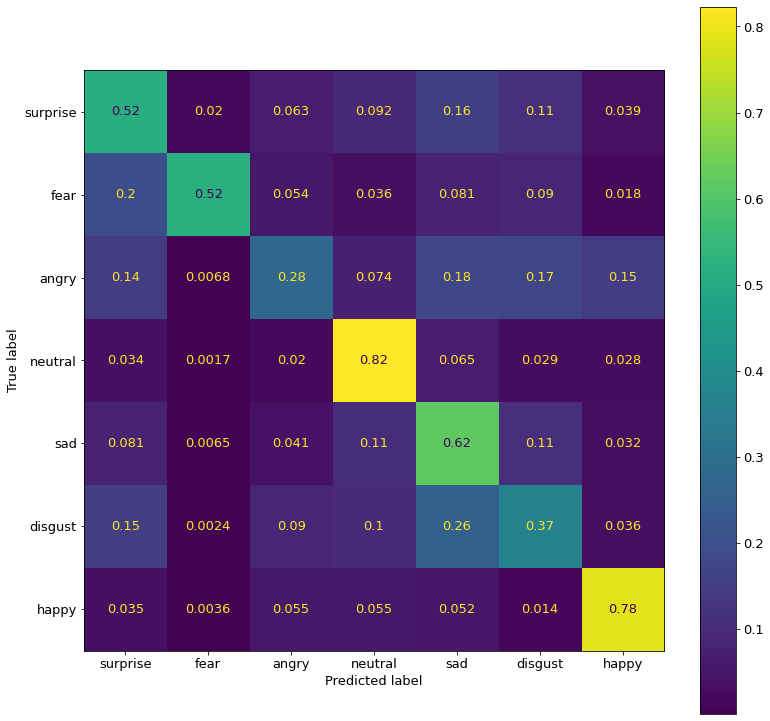

In [32]:
#no weight
auc_fer_ez, uacc_fer_ez, wacc_fer_ez = weight_testing_FER(model_VF_04, CNN_MORE_W+'02drop_noweight.h5', test_set_48)


Surprise accuracy: 0.35386221294363257
Fear accuracy: 0.18018018018018017
Angry accuracy: 0.12109375
Neutral accuracy: 0.7750845546786922
Sad accuracy: 0.3033252230332522
Disgust accuracy: 0.8291900561347233
Happy accuracy: 0.6401925391095066

              precision    recall  f1-score   support

    surprise       0.53      0.35      0.42       958
        fear       0.56      0.18      0.27       111
       angry       0.48      0.12      0.19      1024
     neutral       0.76      0.78      0.77      1774
         sad       0.64      0.30      0.41      1233
     disgust       0.33      0.83      0.47      1247
       happy       0.74      0.64      0.69       831

    accuracy                           0.53      7178
   macro avg       0.58      0.46      0.46      7178
weighted avg       0.59      0.53      0.51      7178

Unweighted Accuracy: 0.5291167456115909
Weighted Accuracy: 0.4575612165828553


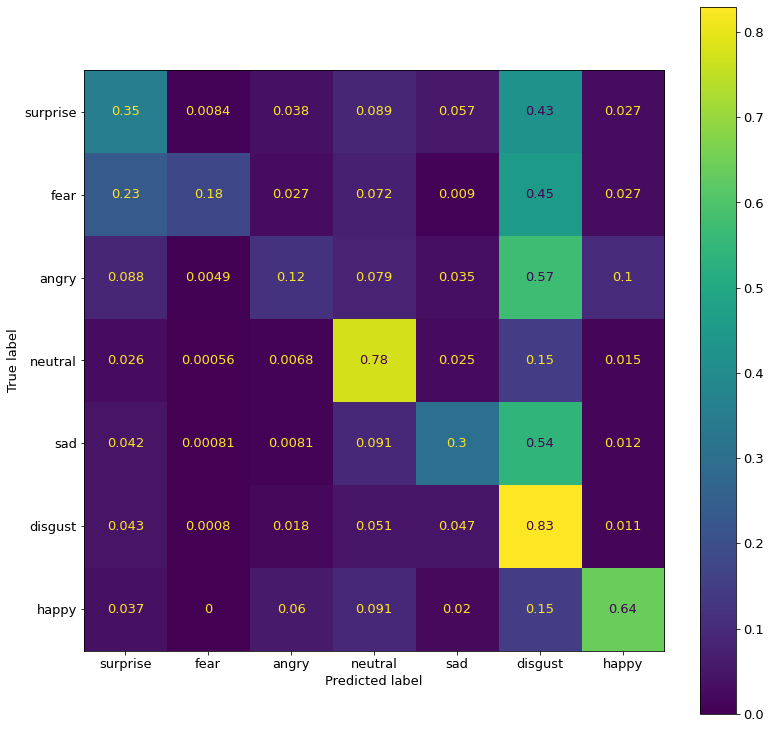

In [33]:
auc_fer_ez, uacc_fer_ez, wacc_fer_ez = weight_testing_FER(model_VF_04, CNN_NEW_WEIGHTS+'FirstCnn/create_model_VF_04_model_2.h5', test_set_48)


Surprise accuracy: 0.4822546972860125
Fear accuracy: 0.43243243243243246
Angry accuracy: 0.291015625
Neutral accuracy: 0.8038331454340474
Sad accuracy: 0.6317923763179237
Disgust accuracy: 0.4161988773055333
Happy accuracy: 0.7280385078219013

              precision    recall  f1-score   support

    surprise       0.49      0.48      0.48       958
        fear       0.52      0.43      0.47       111
       angry       0.46      0.29      0.36      1024
     neutral       0.79      0.80      0.80      1774
         sad       0.48      0.63      0.55      1233
     disgust       0.44      0.42      0.43      1247
       happy       0.68      0.73      0.71       831

    accuracy                           0.58      7178
   macro avg       0.55      0.54      0.54      7178
weighted avg       0.57      0.58      0.57      7178

Unweighted Accuracy: 0.5763443856227362
Weighted Accuracy: 0.5407950945139787


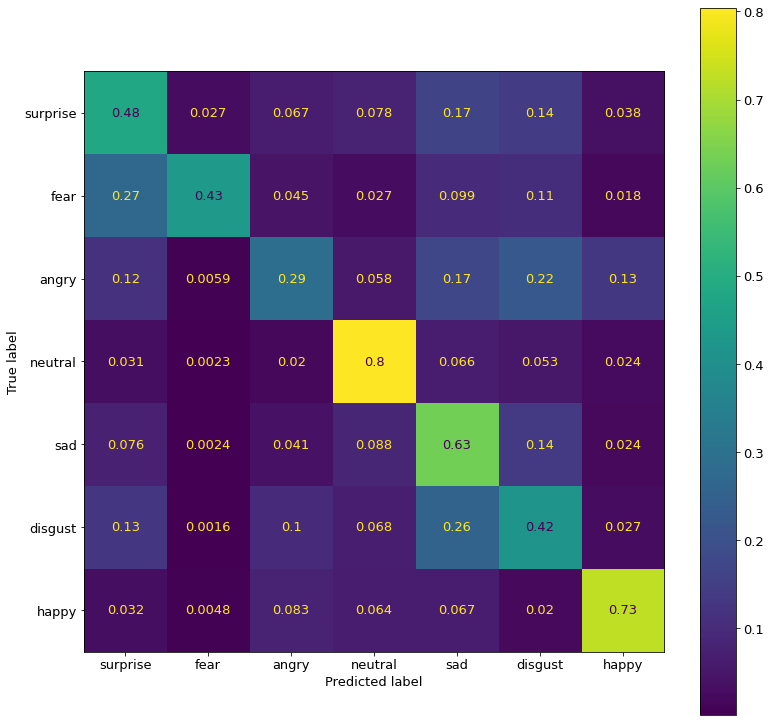

In [34]:
#no weight
auc_fer_ez, uacc_fer_ez, wacc_fer_ez = weight_testing_FER(model_VF_04, CNN_MORE_W+'04dropout_noweight.h5', test_set_48)

## Experiment 2


In [35]:
res_uw = []
res_w = []
vgg_uw = []
vgg_w = []

## ResNet 0

In [36]:
# Weights transfer_learning_model_resnet_50_20epochs/transfer_learning_model_resnet_50_model_1.h5
def transfer_learning_model_resnet_50_0():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  #print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 400
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_resnet_50_0 = transfer_learning_model_resnet_50_0()
transfer_model_resnet_50_0.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
____________________________________________________________


Surprise accuracy: 0.07620041753653445
Fear accuracy: 0.009009009009009009
Angry accuracy: 0.11328125
Neutral accuracy: 0.2897406989853439
Sad accuracy: 0.0665044606650446
Disgust accuracy: 0.9390537289494787
Happy accuracy: 0.29843561973525873

              precision    recall  f1-score   support

    surprise       0.41      0.08      0.13       958
        fear       0.50      0.01      0.02       111
       angry       0.36      0.11      0.17      1024
     neutral       0.66      0.29      0.40      1774
         sad       0.63      0.07      0.12      1233
     disgust       0.21      0.94      0.35      1247
       happy       0.78      0.30      0.43       831

    accuracy                           0.31      7178
   macro avg       0.51      0.26      0.23      7178
weighted avg       0.51      0.31      0.27      7178

Unweighted Accuracy: 0.30718863193089996
Weighted Accuracy: 0.256032169268667


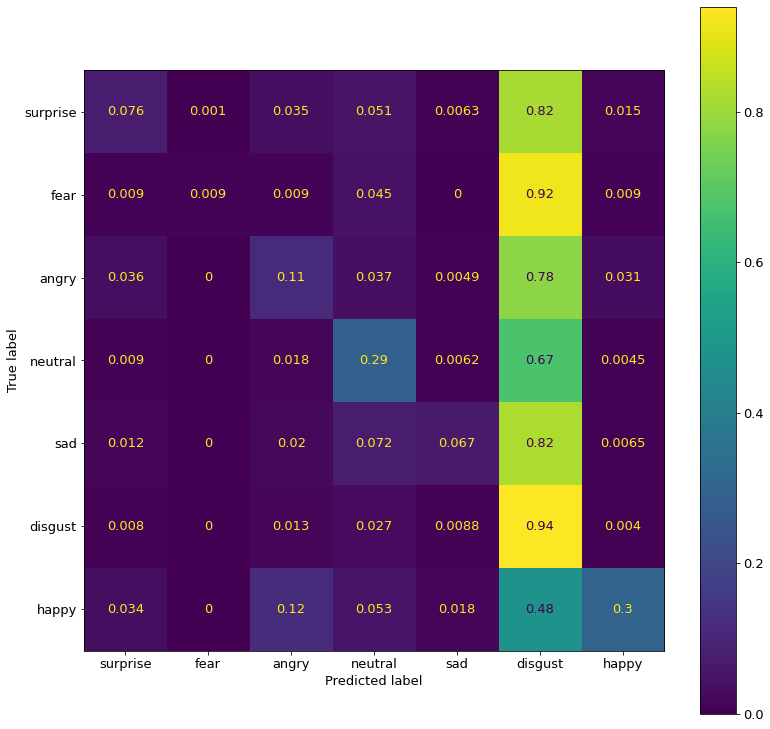

In [37]:
#new

auc_fer_ez, uacc_fer_0, wacc_fer_0 = weight_testing_FER(transfer_model_resnet_50_0, CNN_MORE_W+'res_0l.h5', test_set_48)

## Res 120


In [38]:
def transfer_learning_model_resnet_50_120():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 120
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_resnet_50_120 = transfer_learning_model_resnet_50_120()
transfer_model_resnet_50_120.summary()

175
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_5 (TFOpLambda (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 


Surprise accuracy: 0.4112734864300626
Fear accuracy: 0.4864864864864865
Angry accuracy: 0.4033203125
Neutral accuracy: 0.7491544532130778
Sad accuracy: 0.44849959448499593
Disgust accuracy: 0.5565356856455493
Happy accuracy: 0.7196149217809867

              precision    recall  f1-score   support

    surprise       0.50      0.41      0.45       958
        fear       0.74      0.49      0.59       111
       angry       0.47      0.40      0.43      1024
     neutral       0.72      0.75      0.73      1774
         sad       0.51      0.45      0.48      1233
     disgust       0.41      0.56      0.48      1247
       happy       0.72      0.72      0.72       831

    accuracy                           0.56      7178
   macro avg       0.58      0.54      0.55      7178
weighted avg       0.57      0.56      0.56      7178

Unweighted Accuracy: 0.5621342992477013
Weighted Accuracy: 0.5392692772201656


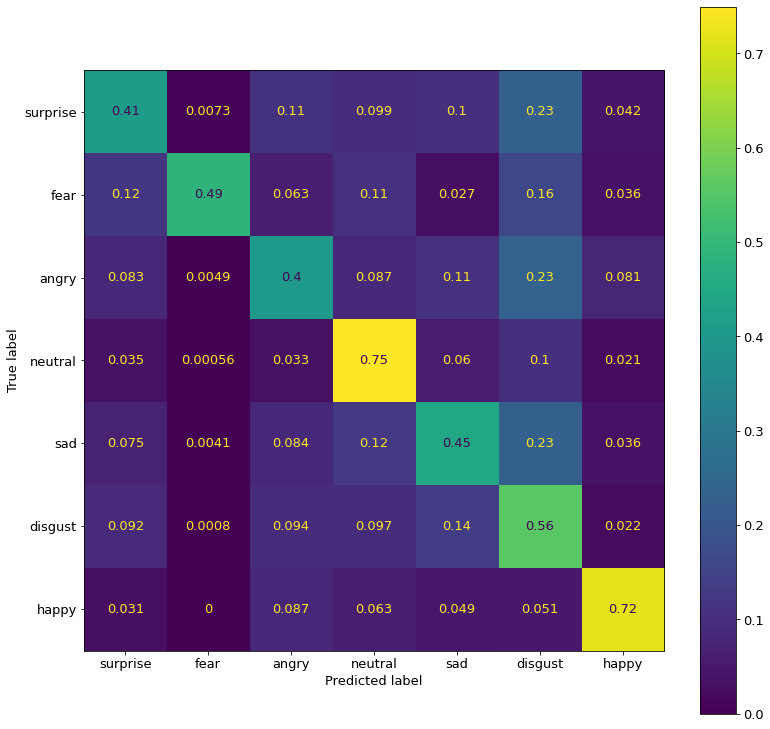

In [39]:
auc_fer_ez, uacc_fer_120, wacc_fer_120 = weight_testing_FER(transfer_model_resnet_50_120, CNN_MORE_W+'res_120l.h5', test_set_48)

## Res 130

In [40]:
def transfer_learning_model_resnet_50_130():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 130
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_resnet_50_130 = transfer_learning_model_resnet_50_130()
transfer_model_resnet_50_130.summary()

175
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 


Surprise accuracy: 0.44154488517745305
Fear accuracy: 0.5405405405405406
Angry accuracy: 0.380859375
Neutral accuracy: 0.7294250281848929
Sad accuracy: 0.5012165450121655
Disgust accuracy: 0.5236567762630313
Happy accuracy: 0.7196149217809867

              precision    recall  f1-score   support

    surprise       0.49      0.44      0.47       958
        fear       0.83      0.54      0.66       111
       angry       0.53      0.38      0.44      1024
     neutral       0.70      0.73      0.72      1774
         sad       0.47      0.50      0.49      1233
     disgust       0.42      0.52      0.47      1247
       happy       0.73      0.72      0.73       831

    accuracy                           0.56      7178
   macro avg       0.60      0.55      0.57      7178
weighted avg       0.57      0.56      0.56      7178

Unweighted Accuracy: 0.5622736138200056
Weighted Accuracy: 0.5481225817084386


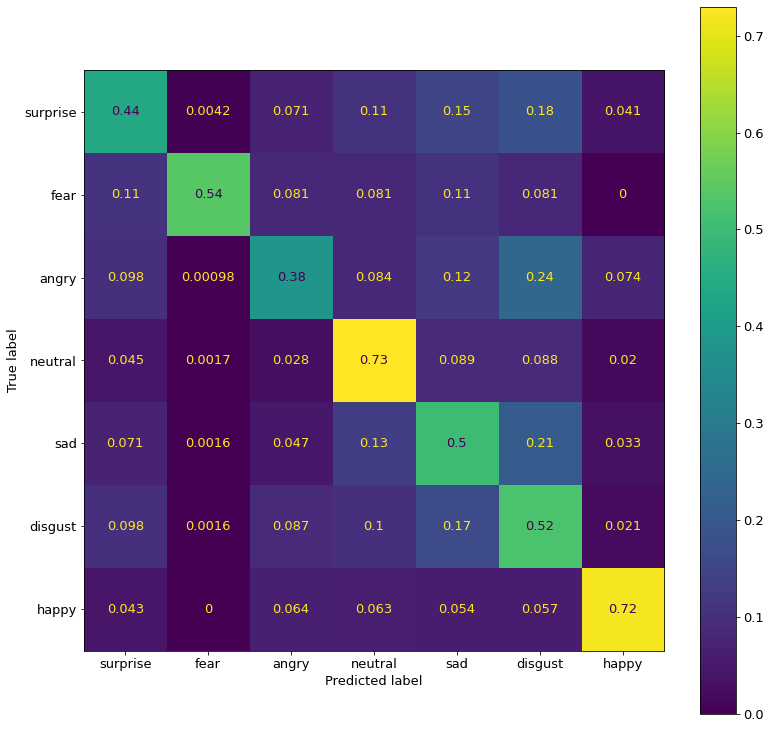

In [41]:
#new
auc_fer_ez, uacc_fer_130, wacc_fer_130 = weight_testing_FER(transfer_model_resnet_50_130, CNN_NEW_WEIGHTS+'130:13/transfer_learning_model_resnet_50_model_4 (1).h5', test_set_48)

In [42]:
res_uw.append(uacc_fer_130)
res_w.append(wacc_fer_130)

## Res 140


In [43]:
def transfer_learning_model_resnet_50_140():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 140
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_resnet_50_140 = transfer_learning_model_resnet_50_140()
transfer_model_resnet_50_140.summary()

175
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_7 (TFOpLambda (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 


Surprise accuracy: 0.4582463465553236
Fear accuracy: 0.4774774774774775
Angry accuracy: 0.3740234375
Neutral accuracy: 0.7029312288613303
Sad accuracy: 0.5263584752635847
Disgust accuracy: 0.47714514835605454
Happy accuracy: 0.7376654632972323

              precision    recall  f1-score   support

    surprise       0.46      0.46      0.46       958
        fear       0.68      0.48      0.56       111
       angry       0.55      0.37      0.45      1024
     neutral       0.69      0.70      0.70      1774
         sad       0.47      0.53      0.50      1233
     disgust       0.44      0.48      0.46      1247
       happy       0.66      0.74      0.69       831

    accuracy                           0.55      7178
   macro avg       0.57      0.54      0.55      7178
weighted avg       0.56      0.55      0.55      7178

Unweighted Accuracy: 0.5543326831986626
Weighted Accuracy: 0.5362639396158576


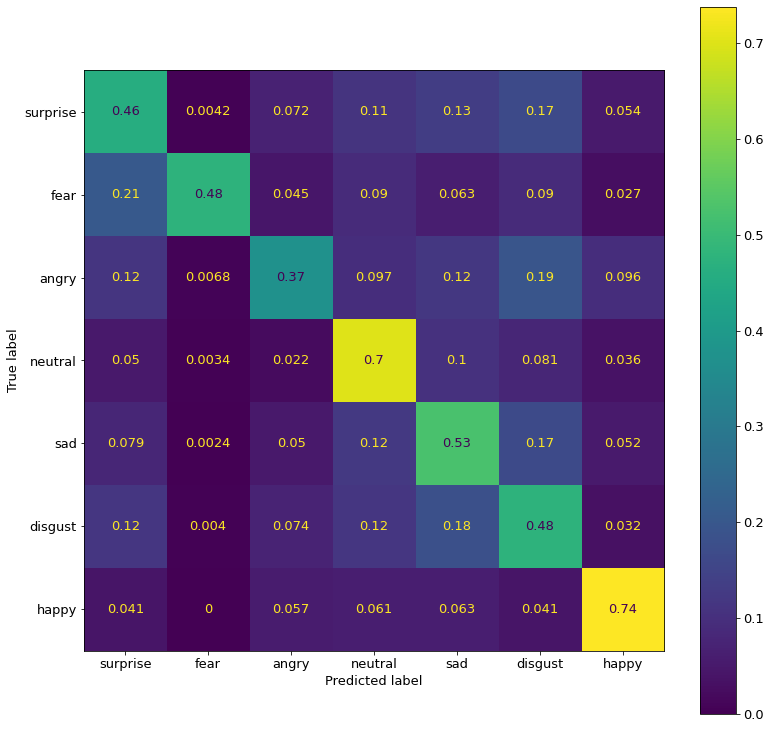

In [44]:
auc_fer_ez, uacc_fer_140, wacc_fer_140 = weight_testing_FER(transfer_model_resnet_50_140, CNN_MORE_W+'Res_140l.h5', test_set_48)

## Res 150

In [45]:
def transfer_learning_model_resnet_50_150():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 150
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_resnet_50_150 = transfer_learning_model_resnet_50_150()
transfer_model_resnet_50_150.summary()

175
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_8 (TFOpLambda (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 7)                 


Surprise accuracy: 0.35281837160751567
Fear accuracy: 0.44144144144144143
Angry accuracy: 0.400390625
Neutral accuracy: 0.6662908680947013
Sad accuracy: 0.40145985401459855
Disgust accuracy: 0.4843624699278268
Happy accuracy: 0.6401925391095066

              precision    recall  f1-score   support

    surprise       0.42      0.35      0.38       958
        fear       0.64      0.44      0.52       111
       angry       0.41      0.40      0.40      1024
     neutral       0.62      0.67      0.64      1774
         sad       0.46      0.40      0.43      1233
     disgust       0.39      0.48      0.43      1247
       happy       0.70      0.64      0.67       831

    accuracy                           0.50      7178
   macro avg       0.52      0.48      0.50      7178
weighted avg       0.51      0.50      0.50      7178

Unweighted Accuracy: 0.5029256060183895
Weighted Accuracy: 0.4838508813136558


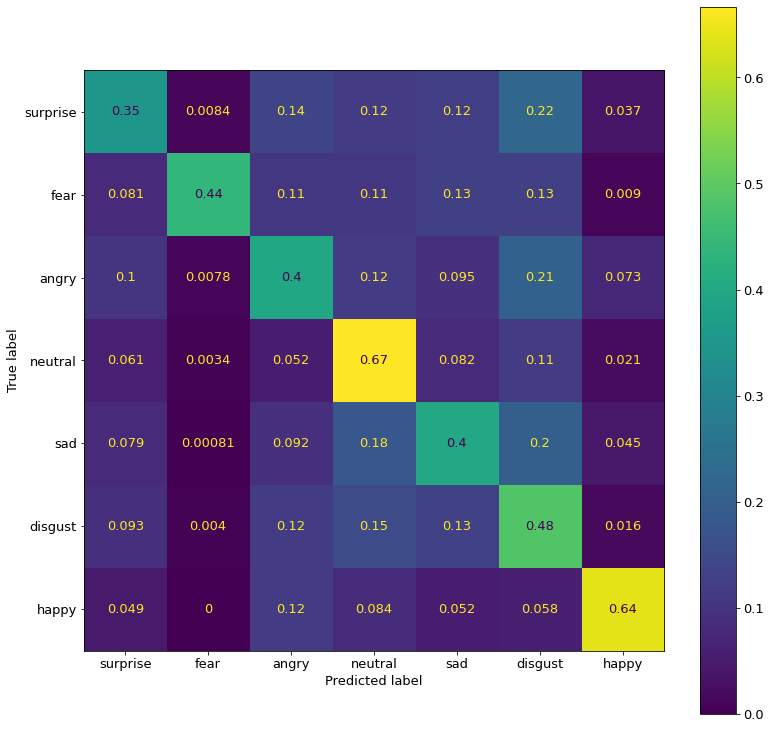

In [46]:
#new 
auc_fer_ez, uacc_fer_150, wacc_fer_150 = weight_testing_FER(transfer_model_resnet_50_150, CNN_NEW_WEIGHTS+'150:15/transfer_learning_model_resnet_50_model_2.h5', test_set_48)

In [47]:
res_uw.append(uacc_fer_150)
res_w.append(wacc_fer_150)

## RESNET 160

In [48]:
def transfer_learning_model_resnet_50_160():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 160
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_resnet_50_160 = transfer_learning_model_resnet_50_160()
transfer_model_resnet_50_160.summary()

175
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_5 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 


Surprise accuracy: 0.4133611691022965
Fear accuracy: 0.5135135135135135
Angry accuracy: 0.3671875
Neutral accuracy: 0.685456595264938
Sad accuracy: 0.41362530413625304
Disgust accuracy: 0.5020048115477145
Happy accuracy: 0.6859205776173285

              precision    recall  f1-score   support

    surprise       0.42      0.41      0.42       958
        fear       0.59      0.51      0.55       111
       angry       0.50      0.37      0.42      1024
     neutral       0.61      0.69      0.64      1774
         sad       0.48      0.41      0.45      1233
     disgust       0.41      0.50      0.45      1247
       happy       0.71      0.69      0.70       831

    accuracy                           0.52      7178
   macro avg       0.53      0.51      0.52      7178
weighted avg       0.52      0.52      0.52      7178

Unweighted Accuracy: 0.5225689607132906
Weighted Accuracy: 0.5115813530260063


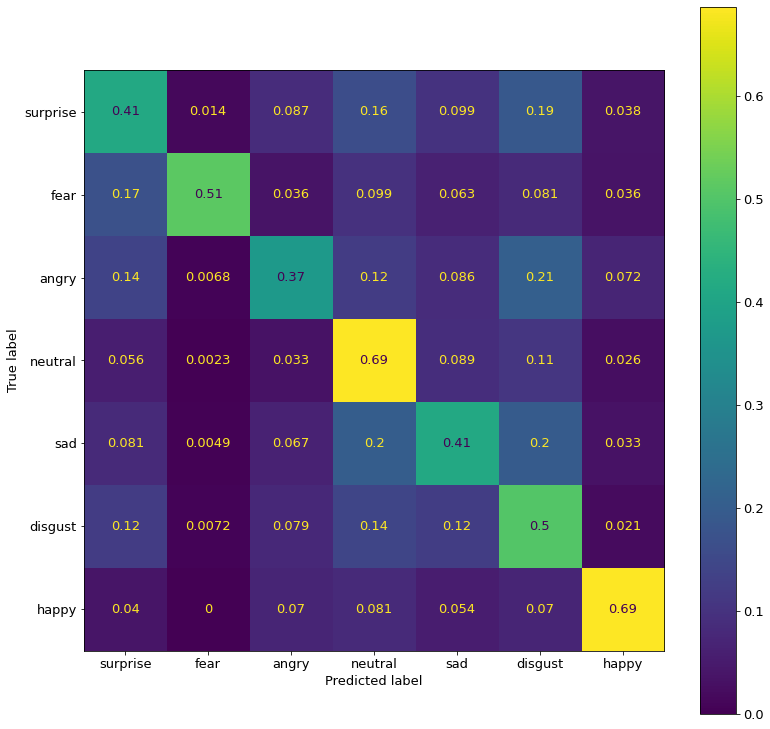

In [49]:
#new
auc_fer_ez, uacc_fer_160, wacc_fer_160 = weight_testing_FER(transfer_model_resnet_50_160, CNN_NEW_WEIGHTS+'160:16/transfer_learning_model_resnet_50_model_3.h5', test_set_48)

In [50]:
res_uw.append(uacc_fer_160)
res_w.append(wacc_fer_160)

In [51]:
res_uw.append(uacc_fer_0)
res_w.append(wacc_fer_0)

## Res 170

In [52]:
def transfer_learning_model_resnet_50_170():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 170
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_resnet_50_170 = transfer_learning_model_resnet_50_170()
transfer_model_resnet_50_170.summary()

175
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_10 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 7)                


Surprise accuracy: 0.33716075156576203
Fear accuracy: 0.3333333333333333
Angry accuracy: 0.3642578125
Neutral accuracy: 0.5963923337091319
Sad accuracy: 0.3706407137064071
Disgust accuracy: 0.5525260625501203
Happy accuracy: 0.5571600481347774

              precision    recall  f1-score   support

    surprise       0.38      0.34      0.36       958
        fear       0.88      0.33      0.48       111
       angry       0.37      0.36      0.37      1024
     neutral       0.61      0.60      0.60      1774
         sad       0.46      0.37      0.41      1233
     disgust       0.37      0.55      0.44      1247
       happy       0.71      0.56      0.63       831

    accuracy                           0.47      7178
   macro avg       0.54      0.44      0.47      7178
weighted avg       0.49      0.47      0.48      7178

Unweighted Accuracy: 0.4736695458344943
Weighted Accuracy: 0.4444958650713617


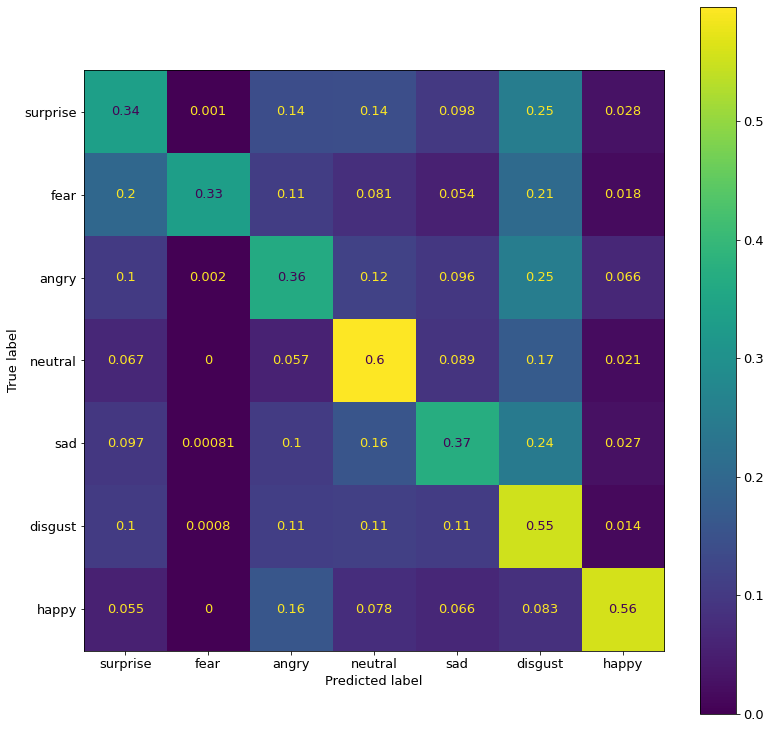

In [53]:
auc_fer_ez, uacc_fer_170, wacc_fer_170 = weight_testing_FER(transfer_model_resnet_50_170, CNN_MORE_W+'res_170l.h5', test_set_48)

## VGG 0

In [54]:
def transfer_learning_model_vgg_16_0():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.vgg16.preprocess_input(inputs)
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = False

  fine_tune_at = 14
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_vgg_16_0 = transfer_learning_model_vgg_16_0()
transfer_model_vgg_16_0.summary()

58900480/58889256 [==============================] - 0s 0us/step
19
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_7 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_11 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
________________________________________________________


Surprise accuracy: 0.04592901878914405
Fear accuracy: 0.0
Angry accuracy: 0.05859375
Neutral accuracy: 0.10992108229988726
Sad accuracy: 0.0494728304947283
Disgust accuracy: 0.884522854851644
Happy accuracy: 0.12755716004813478

              precision    recall  f1-score   support

    surprise       0.16      0.05      0.07       958
        fear       0.00      0.00      0.00       111
       angry       0.19      0.06      0.09      1024
     neutral       0.51      0.11      0.18      1774
         sad       0.26      0.05      0.08      1233
     disgust       0.19      0.88      0.31      1247
       happy       0.64      0.13      0.21       831

    accuracy                           0.22      7178
   macro avg       0.28      0.18      0.14      7178
weighted avg       0.33      0.22      0.16      7178

Unweighted Accuracy: 0.2185845639453887
Weighted Accuracy: 0.18228524235479115


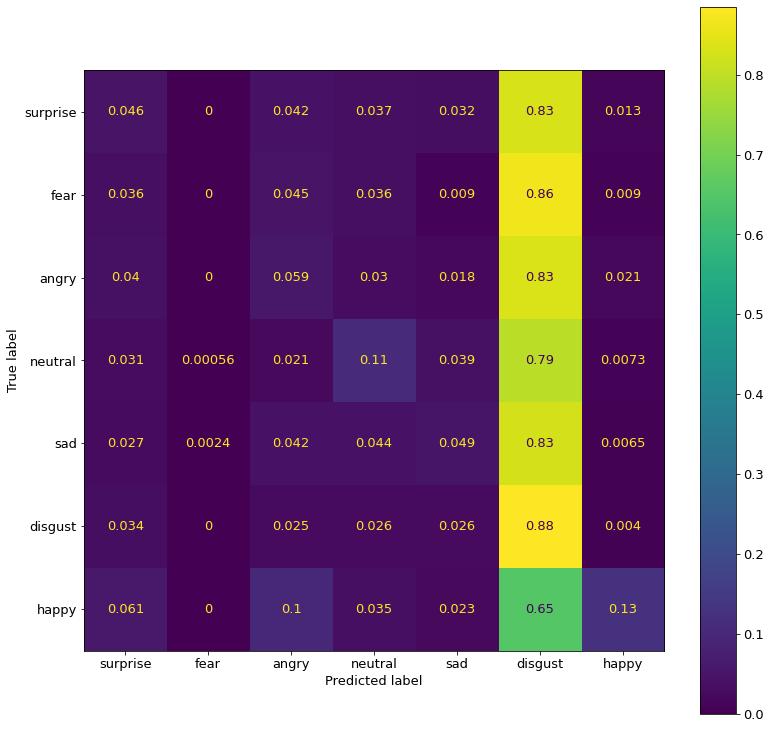

In [55]:
auc_fer_ez, uacc_fer_vgg0, wacc_fer_vgg0 = weight_testing_FER(transfer_model_vgg_16_0, CNN_MORE_W+'vgg_0l.h5', test_set_48)

## Vgg 12

In [56]:
def transfer_learning_model_vgg_16_12():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.vgg16.preprocess_input(inputs)
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 12
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_vgg_16_12 = transfer_learning_model_vgg_16_12()
transfer_model_vgg_16_12.summary()

19
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_12 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 

2022-05-10 20:14:51.147536: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /kaggle/input/even-more-weights/Weights part 2/vgg_12l: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?



Surprise accuracy: 0.47390396659707723
Fear accuracy: 0.4144144144144144
Angry accuracy: 0.3828125
Neutral accuracy: 0.842728297632469
Sad accuracy: 0.570154095701541
Disgust accuracy: 0.5493183640737771
Happy accuracy: 0.7569193742478941

              precision    recall  f1-score   support

    surprise       0.54      0.47      0.51       958
        fear       0.82      0.41      0.55       111
       angry       0.55      0.38      0.45      1024
     neutral       0.75      0.84      0.79      1774
         sad       0.53      0.57      0.55      1233
     disgust       0.50      0.55      0.52      1247
       happy       0.72      0.76      0.74       831

    accuracy                           0.61      7178
   macro avg       0.63      0.57      0.59      7178
weighted avg       0.61      0.61      0.61      7178

Unweighted Accuracy: 0.6135413764279743
Weighted Accuracy: 0.5700358589524532


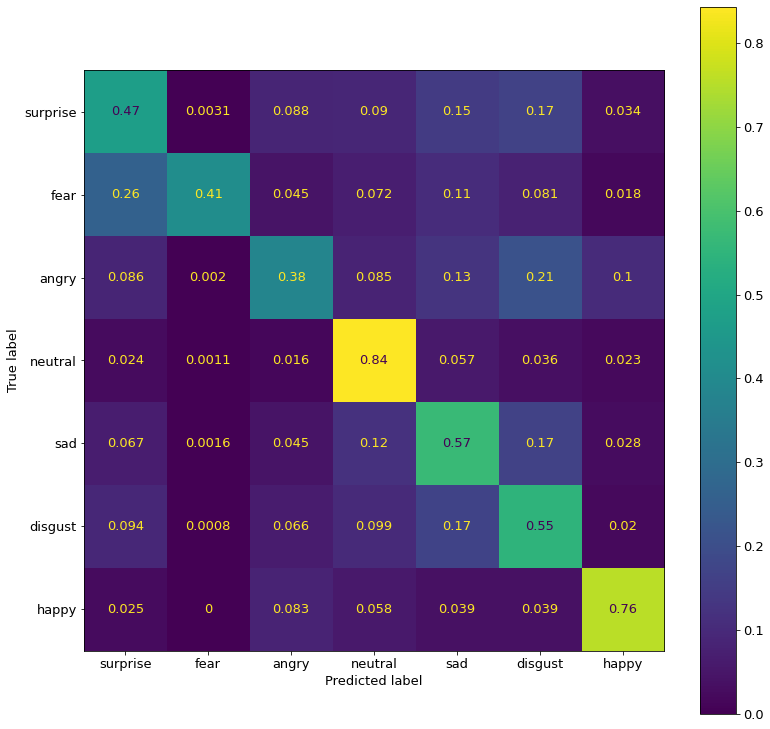

In [57]:
auc_fer_ez, uacc_fer_12, wacc_fer_12 = weight_testing_FER(transfer_model_vgg_16_12, CNN_MORE_W+'vgg_12l', test_set_48)

## VGG 13

In [58]:
# weights: transfer_learning_model_vgg_16_50epochs/transfer_learning_model_vgg_16_model_2.h5
def transfer_learning_model_vgg_16_13():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.vgg16.preprocess_input(inputs)
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True  
  fine_tune_at = 13
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_vgg_16_13 = transfer_learning_model_vgg_16_13()
transfer_model_vgg_16_13.summary()

19
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_13 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_13  (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 7)                 


Surprise accuracy: 0.4352818371607516
Fear accuracy: 0.4864864864864865
Angry accuracy: 0.421875
Neutral accuracy: 0.818489289740699
Sad accuracy: 0.5709651257096513
Disgust accuracy: 0.5300721732157178
Happy accuracy: 0.7304452466907341

              precision    recall  f1-score   support

    surprise       0.57      0.44      0.49       958
        fear       0.77      0.49      0.60       111
       angry       0.50      0.42      0.46      1024
     neutral       0.74      0.82      0.78      1774
         sad       0.49      0.57      0.53      1233
     disgust       0.49      0.53      0.51      1247
       happy       0.77      0.73      0.75       831

    accuracy                           0.60      7178
   macro avg       0.62      0.57      0.59      7178
weighted avg       0.60      0.60      0.60      7178

Unweighted Accuracy: 0.6028141543605461
Weighted Accuracy: 0.5705164512862915


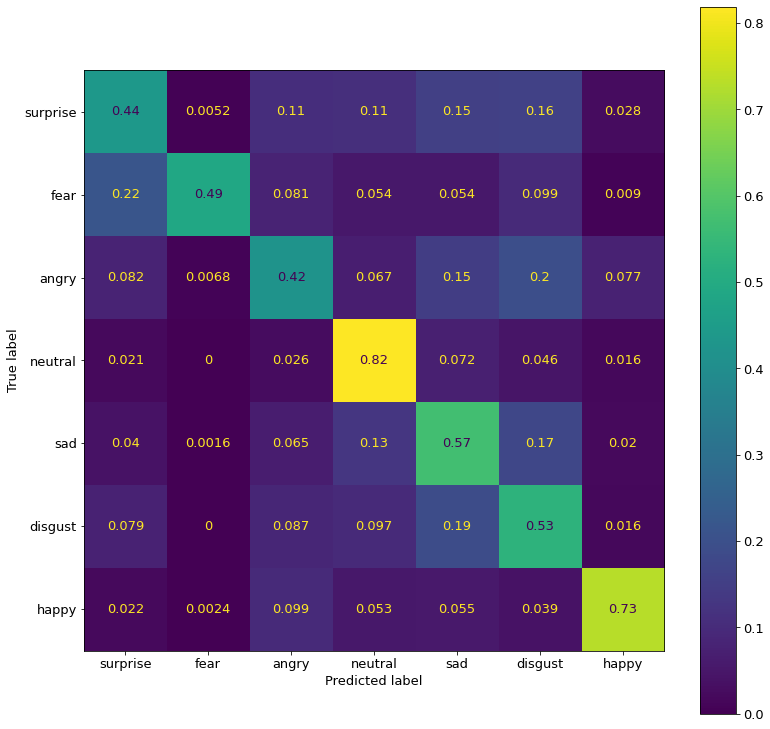

In [59]:
auc_fer_e2, uacc_fer_e2, wacc_fer_e2 = weight_testing_FER(transfer_model_vgg_16_13, CNN_WEIGHTS_02+'transfer_learning_model_vgg_16_model_2.h5', test_set_48)

In [60]:
vgg_uw.append(uacc_fer_e2)
vgg_w.append(wacc_fer_e2)

## Vgg 14


In [61]:
def transfer_learning_model_vgg_16_14():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.vgg16.preprocess_input(inputs)
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 14
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_vgg_16_14 = transfer_learning_model_vgg_16_14()
transfer_model_vgg_16_14.summary()

19
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_10  (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_14 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_14  (None, 512)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 7)                 


Surprise accuracy: 0.4906054279749478
Fear accuracy: 0.43243243243243246
Angry accuracy: 0.42578125
Neutral accuracy: 0.8348365276211951
Sad accuracy: 0.43471208434712083
Disgust accuracy: 0.49799518845228546
Happy accuracy: 0.6582430806257521

              precision    recall  f1-score   support

    surprise       0.44      0.49      0.47       958
        fear       0.77      0.43      0.55       111
       angry       0.46      0.43      0.44      1024
     neutral       0.69      0.83      0.76      1774
         sad       0.56      0.43      0.49      1233
     disgust       0.47      0.50      0.48      1247
       happy       0.80      0.66      0.72       831

    accuracy                           0.58      7178
   macro avg       0.60      0.54      0.56      7178
weighted avg       0.58      0.58      0.57      7178

Unweighted Accuracy: 0.5766230147673447
Weighted Accuracy: 0.5392294273505334


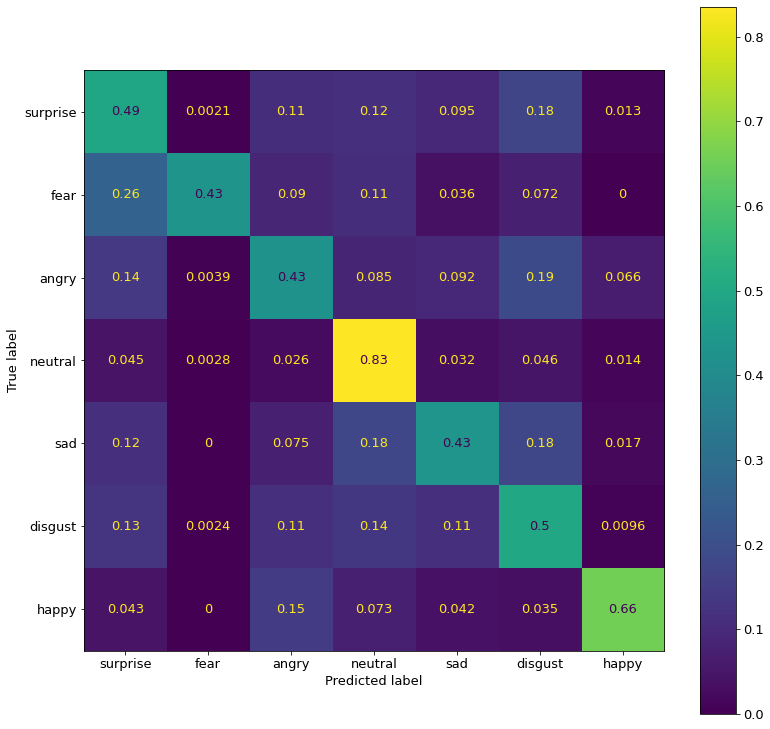

In [62]:
auc_fer_ez, uacc_fer_14, wacc_fer_14 = weight_testing_FER(transfer_model_vgg_16_14, CNN_MORE_W+'vgg_14l.h5', test_set_48)

## VGG 15

In [63]:
def transfer_learning_model_vgg_16_15():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.vgg16.preprocess_input(inputs)
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 15
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_vgg_16_15 = transfer_learning_model_vgg_16_15()
transfer_model_vgg_16_15.summary()

19
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_11  (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_15 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_15  (None, 512)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 7)                 


Surprise accuracy: 0.4592901878914405
Fear accuracy: 0.5225225225225225
Angry accuracy: 0.43359375
Neutral accuracy: 0.7846674182638106
Sad accuracy: 0.5563665855636658
Disgust accuracy: 0.5188452285485164
Happy accuracy: 0.6750902527075813

              precision    recall  f1-score   support

    surprise       0.52      0.46      0.49       958
        fear       0.83      0.52      0.64       111
       angry       0.53      0.43      0.48      1024
     neutral       0.75      0.78      0.77      1774
         sad       0.47      0.56      0.51      1233
     disgust       0.46      0.52      0.49      1247
       happy       0.82      0.68      0.74       831

    accuracy                           0.59      7178
   macro avg       0.62      0.56      0.59      7178
weighted avg       0.60      0.59      0.59      7178

Unweighted Accuracy: 0.5890220117024241
Weighted Accuracy: 0.5643394207853624


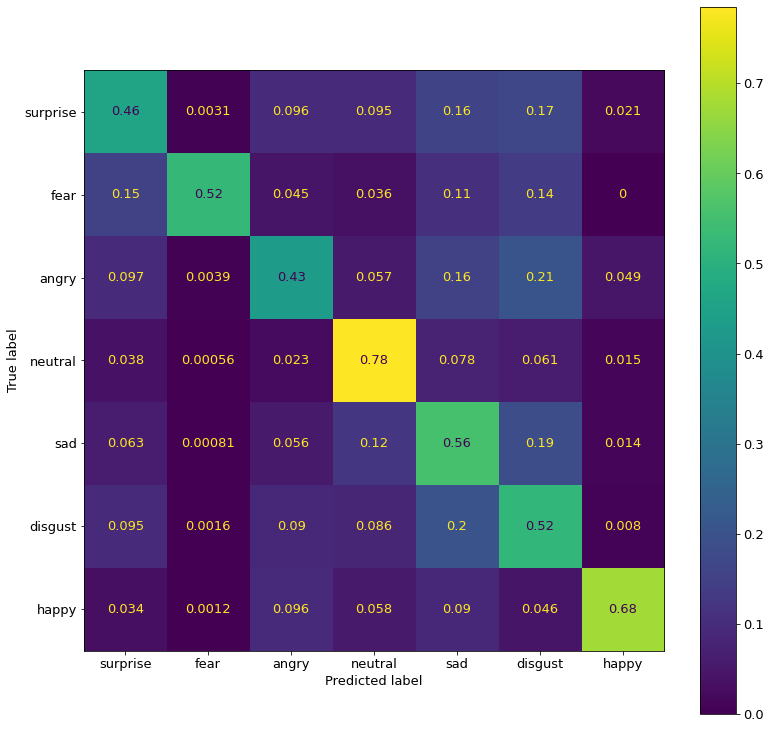

In [64]:
#new
auc_fer_ez, uacc_fer_15, wacc_fer_15 = weight_testing_FER(transfer_model_vgg_16_15, CNN_NEW_WEIGHTS+'150:15/transfer_learning_model_vgg_16_model_4.h5', test_set_48)

In [65]:
vgg_uw.append(uacc_fer_15)
vgg_w.append(wacc_fer_15)

## VGG 16

In [66]:
def transfer_learning_model_vgg_16_16():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.vgg16.preprocess_input(inputs)
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 16
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_vgg_16_16 = transfer_learning_model_vgg_16_16()
transfer_model_vgg_16_16.summary()

19
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_12  (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_16 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_16  (None, 512)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 


Surprise accuracy: 0.48434237995824636
Fear accuracy: 0.35135135135135137
Angry accuracy: 0.3408203125
Neutral accuracy: 0.6640360766629086
Sad accuracy: 0.5815085158150851
Disgust accuracy: 0.4907778668805132
Happy accuracy: 0.641395908543923

              precision    recall  f1-score   support

    surprise       0.41      0.48      0.45       958
        fear       0.80      0.35      0.49       111
       angry       0.45      0.34      0.39      1024
     neutral       0.80      0.66      0.72      1774
         sad       0.44      0.58      0.50      1233
     disgust       0.44      0.49      0.46      1247
       happy       0.74      0.64      0.69       831

    accuracy                           0.54      7178
   macro avg       0.58      0.51      0.53      7178
weighted avg       0.57      0.54      0.55      7178

Unweighted Accuracy: 0.5422123154081917
Weighted Accuracy: 0.5077474873874326


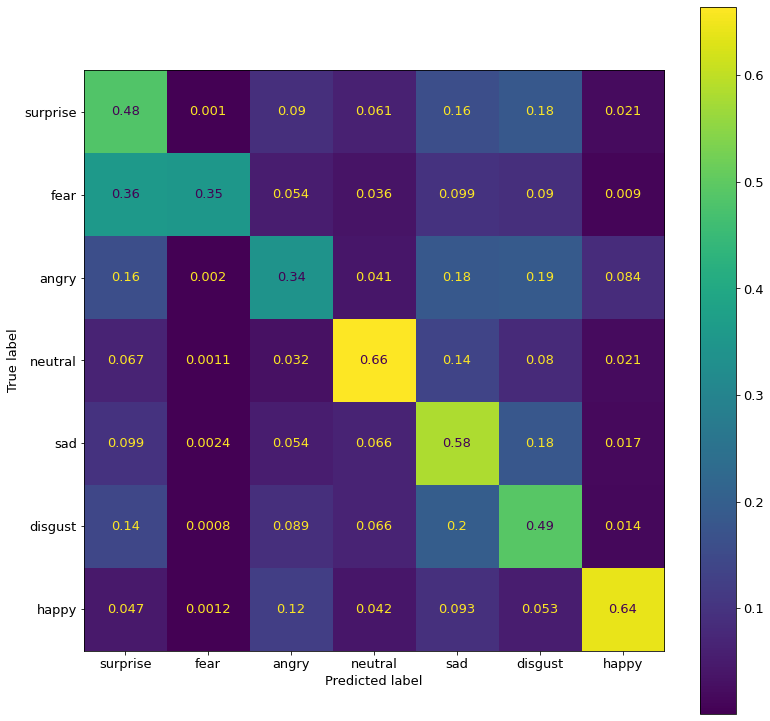

In [67]:
#new
auc_fer_ez, uacc_fer_16, wacc_fer_16 = weight_testing_FER(transfer_model_vgg_16_16, CNN_NEW_WEIGHTS+'160:16/transfer_learning_model_vgg_16_model_2.h5', test_set_48)

In [68]:
vgg_uw.append(uacc_fer_16)
vgg_w.append(wacc_fer_16)

## Vgg 17

In [69]:
def transfer_learning_model_vgg_16_17():

  IMG_SHAPE = (48,48,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.vgg16.preprocess_input(inputs)
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 17
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_vgg_16_17 = transfer_learning_model_vgg_16_17()
transfer_model_vgg_16_17.summary()

19
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_13  (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_17 (TFOpLambd (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_17  (None, 512)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 7)                 


Surprise accuracy: 0.18684759916492694
Fear accuracy: 0.0
Angry accuracy: 0.06640625
Neutral accuracy: 0.32919954904171367
Sad accuracy: 0.012976480129764802
Disgust accuracy: 0.946271050521251
Happy accuracy: 0.3658243080625752

              precision    recall  f1-score   support

    surprise       0.51      0.19      0.27       958
        fear       0.00      0.00      0.00       111
       angry       0.33      0.07      0.11      1024
     neutral       0.76      0.33      0.46      1774
         sad       0.42      0.01      0.03      1233
     disgust       0.22      0.95      0.35      1247
       happy       0.80      0.37      0.50       831

    accuracy                           0.32      7178
   macro avg       0.43      0.27      0.25      7178
weighted avg       0.51      0.32      0.29      7178

Unweighted Accuracy: 0.3247422680412371
Weighted Accuracy: 0.2725036052743188


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



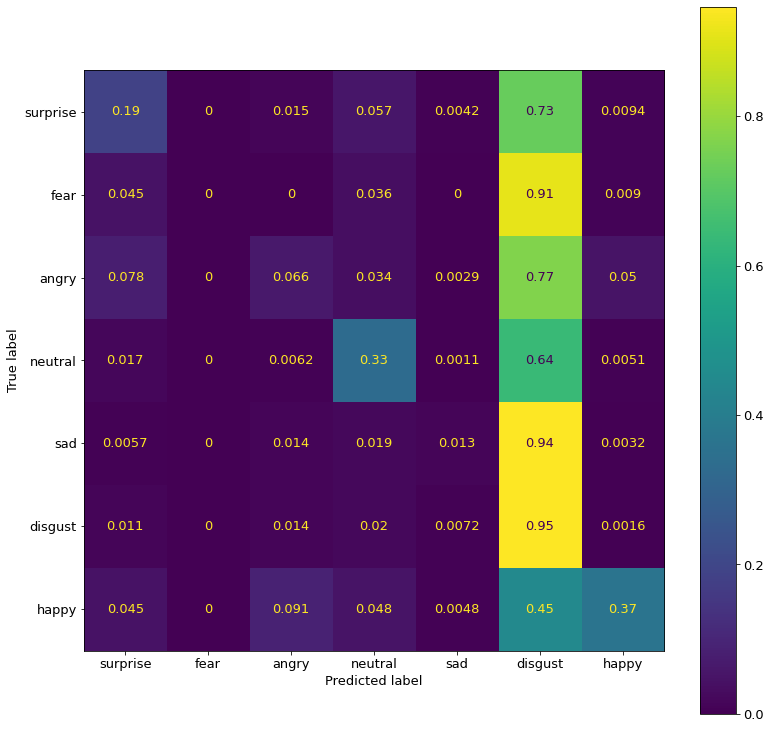

In [70]:
auc_fer_ez, uacc_fer_17, wacc_fer_17 = weight_testing_FER(transfer_model_vgg_16_17, CNN_MORE_W+'vgg_17l.h5', test_set_48)

## Experiment 3


Surprise accuracy: 0.4906054279749478
Fear accuracy: 0.43243243243243246
Angry accuracy: 0.3935546875
Neutral accuracy: 0.7519729425028185
Sad accuracy: 0.5563665855636658
Disgust accuracy: 0.53728949478749
Happy accuracy: 0.6895306859205776

              precision    recall  f1-score   support

    surprise       0.49      0.49      0.49       958
        fear       0.73      0.43      0.54       111
       angry       0.46      0.39      0.43      1024
     neutral       0.79      0.75      0.77      1774
         sad       0.51      0.56      0.53      1233
     disgust       0.45      0.54      0.49      1247
       happy       0.76      0.69      0.72       831

    accuracy                           0.58      7178
   macro avg       0.60      0.55      0.57      7178
weighted avg       0.59      0.58      0.59      7178

Unweighted Accuracy: 0.5828921705210365
Weighted Accuracy: 0.5502503223831332


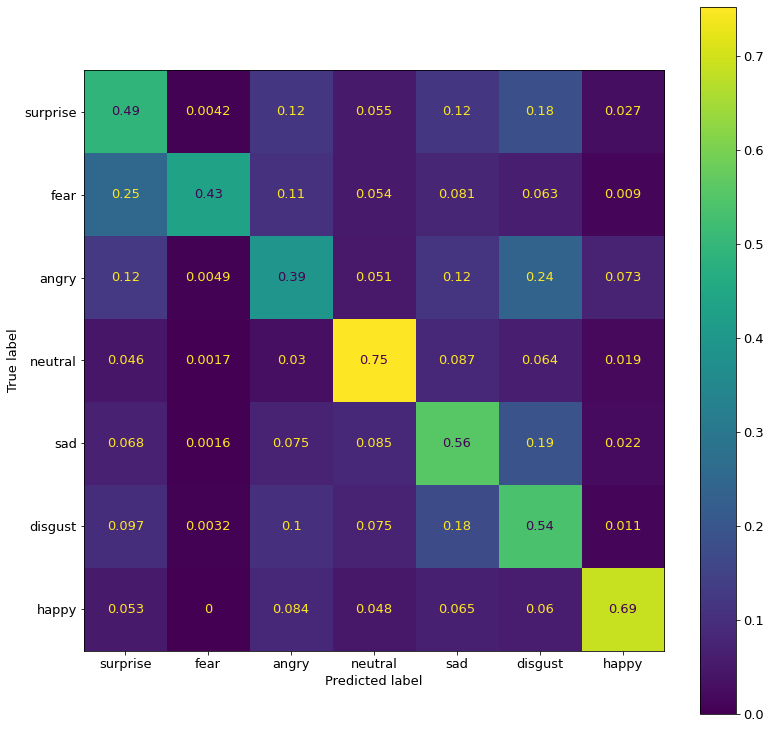

In [71]:
# transfer_learning_model_vgg_16_40epochs/transfer_learning_model_vgg_16_model_5.h5
# Same model 

auc_fer_e3, uacc_fer_e3, wacc_fer_e3 = weight_testing_FER(transfer_model_vgg_16_13, CNN_WEIGHTS_02+'transfer_learning_model_vgg_16_model_5.h5', test_set_48)


Surprise accuracy: 0.44154488517745305
Fear accuracy: 0.5405405405405406
Angry accuracy: 0.380859375
Neutral accuracy: 0.7294250281848929
Sad accuracy: 0.5012165450121655
Disgust accuracy: 0.5236567762630313
Happy accuracy: 0.7196149217809867

              precision    recall  f1-score   support

    surprise       0.49      0.44      0.47       958
        fear       0.83      0.54      0.66       111
       angry       0.53      0.38      0.44      1024
     neutral       0.70      0.73      0.72      1774
         sad       0.47      0.50      0.49      1233
     disgust       0.42      0.52      0.47      1247
       happy       0.73      0.72      0.73       831

    accuracy                           0.56      7178
   macro avg       0.60      0.55      0.57      7178
weighted avg       0.57      0.56      0.56      7178

Unweighted Accuracy: 0.5622736138200056
Weighted Accuracy: 0.5481225817084386


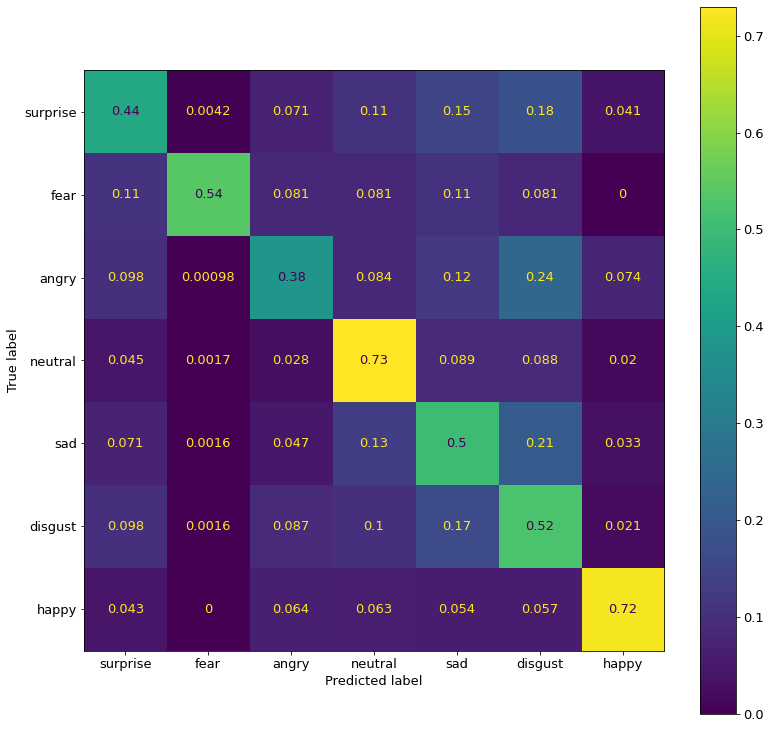

In [72]:
##USES RES 130
#Aug
auc_fer_ez, uacc_fer_ez, wacc_fer_ez = weight_testing_FER(transfer_model_resnet_50_130, CNN_NEW_WEIGHTS+'130:13/transfer_learning_model_resnet_50_model_4 (1).h5', test_set_48)

## Experiment 4

In [73]:
# Weights : transfer_learning_model_resnet_50_50epochs/transfer_learning_model_resnet_50_model_2.h5

def transfer_learning_model_resnet_50_130_big():

  IMG_SHAPE = (224,224,3,)
 
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #inputs = tf.image.grayscale_to_rgb(y)
 
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3,),
                                               include_top=False,
                                               weights='imagenet')
  print(len(base_model.layers))
  base_model.trainable = True

  fine_tune_at = 130
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  x = base_model(x)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  prediction_layer = tf.keras.layers.Dense(7, activation = "softmax")
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #print(len(model.trainable_variables))
  return model

transfer_model_resnet_50_130_big = transfer_learning_model_resnet_50_130_big()

175



Surprise accuracy: 0.4509394572025052
Fear accuracy: 0.5135135135135135
Angry accuracy: 0.451171875
Neutral accuracy: 0.8297632468996617
Sad accuracy: 0.5904298459042985
Disgust accuracy: 0.6904570970328789
Happy accuracy: 0.7099879663056559

              precision    recall  f1-score   support

    surprise       0.61      0.45      0.52       958
        fear       0.77      0.51      0.62       111
       angry       0.53      0.45      0.49      1024
     neutral       0.85      0.83      0.84      1774
         sad       0.62      0.59      0.61      1233
     disgust       0.45      0.69      0.54      1247
       happy       0.83      0.71      0.77       831

    accuracy                           0.64      7178
   macro avg       0.67      0.61      0.63      7178
weighted avg       0.66      0.64      0.64      7178

Unweighted Accuracy: 0.6411256617442185
Weighted Accuracy: 0.6051804288369306


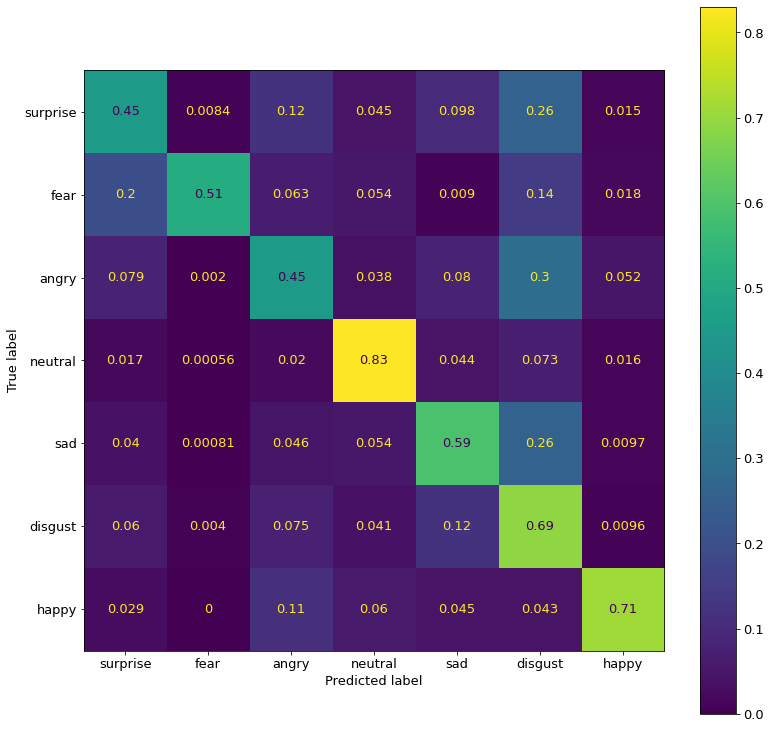

In [74]:
auc_fer_e4, uacc_fer_e4, wacc_fer_e4 = weight_testing_FER(transfer_model_resnet_50_130_big, CNN_WEIGHTS_02+'transfer_learning_model_resnet_50_model_2.h5', test_set_224)

In [75]:
def class_Acc(model, weights, test_set):
    model.load_weights(weights)
    predictions = model.predict(test_set)
    #predict_final = np.where(predictions >=0, 1,0)
    predict_final = tf.argmax(predictions, axis=-1)
    conf_mat = confusion_matrix(test_set.classes, predict_final)
    conf_mat_perc = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    class_acc = conf_mat_perc.diagonal()
    return class_acc

class_acc1 = class_Acc(transfer_model_vgg_16_13, CNN_WEIGHTS_02+'transfer_learning_model_vgg_16_model_2.h5', test_set_48)#Small size
class_acc2 = class_Acc(transfer_model_resnet_50_130_big, CNN_WEIGHTS_02+'transfer_learning_model_resnet_50_model_2.h5', test_set_224 )#big size
data = []
x_ax = ['48x48', '224x224']
for i in range(len(my_list)):
    data.append(go.Bar(name = my_list[i], x = x_ax, y = [class_acc1[i], class_acc2[i]]))
    
fig = go.Figure(data=data)
fig.update_layout(barmode='group')
fig.update_layout(
    title = 'Image Size Comparison',
    title_x = 0.5,
    xaxis_title='Image Dimension',
    yaxis_title='Accuracy',
)
fig.show()


## Experiment 5


Surprise accuracy: 0.48956158663883087
Fear accuracy: 0.4864864864864865
Angry accuracy: 0.3740234375
Neutral accuracy: 0.8624577226606539
Sad accuracy: 0.5223033252230332
Disgust accuracy: 0.6150761828388132
Happy accuracy: 0.7713598074608905

              precision    recall  f1-score   support

    surprise       0.54      0.49      0.51       958
        fear       0.82      0.49      0.61       111
       angry       0.57      0.37      0.45      1024
     neutral       0.76      0.86      0.81      1774
         sad       0.60      0.52      0.56      1233
     disgust       0.48      0.62      0.54      1247
       happy       0.74      0.77      0.75       831

    accuracy                           0.63      7178
   macro avg       0.64      0.59      0.60      7178
weighted avg       0.62      0.63      0.62      7178

Unweighted Accuracy: 0.6252438005015325
Weighted Accuracy: 0.5887526498298155


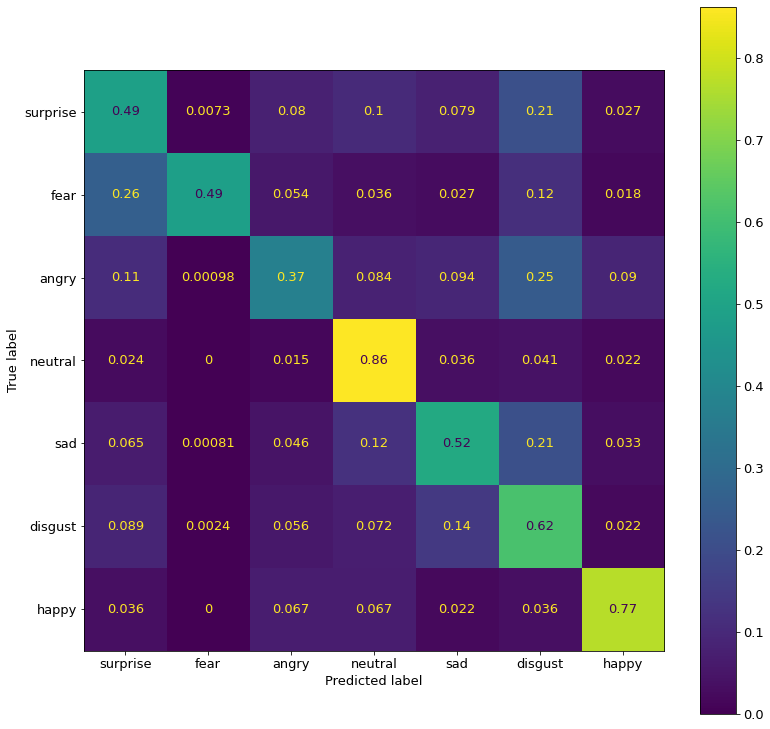

In [76]:
#weights : transfer_learning_model_resnet_50_30epochs/transfer_learning_model_resnet_50_model_3.h5
# Same model
auc_fer_e5, uacc_fer_e5, wacc_fer_e5 = weight_testing_FER(transfer_model_resnet_50_130_big, CNN_WEIGHTS_02+'transfer_learning_model_resnet_50_model_3.h5', test_set_224)

## Experiment 6


Surprise accuracy: 0.5229645093945721
Fear accuracy: 0.5405405405405406
Angry accuracy: 0.443359375
Neutral accuracy: 0.8179255918827508
Sad accuracy: 0.6536901865369019
Disgust accuracy: 0.5886126704089816
Happy accuracy: 0.7448856799037304

              precision    recall  f1-score   support

    surprise       0.57      0.52      0.55       958
        fear       0.68      0.54      0.60       111
       angry       0.52      0.44      0.48      1024
     neutral       0.87      0.82      0.84      1774
         sad       0.56      0.65      0.60      1233
     disgust       0.50      0.59      0.54      1247
       happy       0.78      0.74      0.76       831

    accuracy                           0.64      7178
   macro avg       0.64      0.62      0.63      7178
weighted avg       0.65      0.64      0.65      7178

Unweighted Accuracy: 0.6443298969072165
Weighted Accuracy: 0.6159969362382112


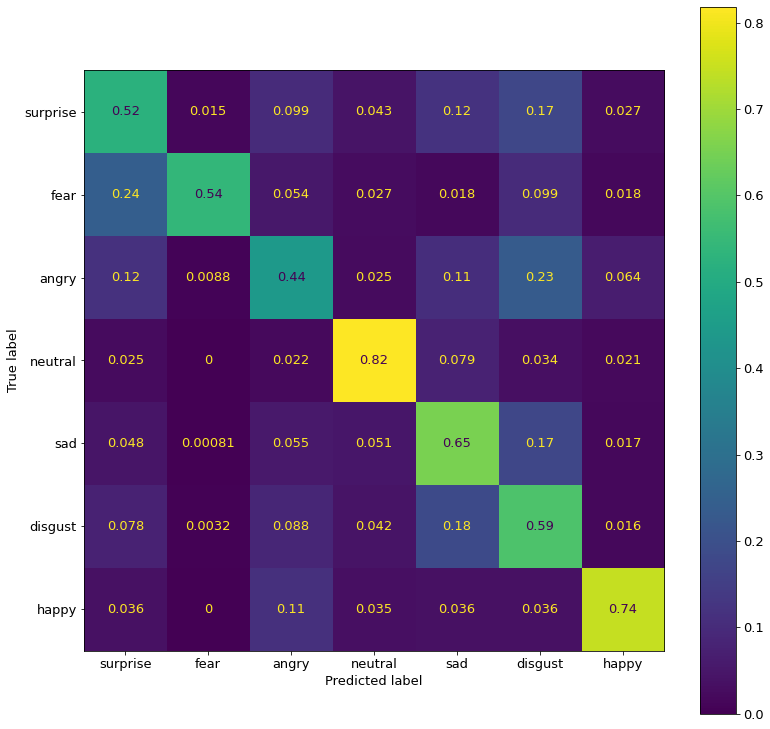

In [77]:
#weights: transfer_learning_model_resnet_50_50epochs/transfer_learning_model_resnet_50_model_3.h5
# Same model
auc_fer_e6, uacc_fer_e6, wacc_fer_e6 = weight_testing_FER(transfer_model_resnet_50_130_big, final_weight, test_set_224)

In [78]:
x = ['2 Layers', '3 Layers',  '4 Layers', '5 Layers', '6 Layers']
print(len(x))
unweighted = [0.7355, 0.7355, 0.7851, 0.7685, 0.7355]
weighted = [68.6, 72.31, 73.49, 75.93, 72.31, 71.57, 82.41, 79.73, 69.93]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=unweighted, name="Accuracy", mode='lines+markers'))
#fig.add_trace(go.Scatter(x=x, y=weighted, name="Weighted Accuracy", mode='lines+markers'))

fig.update_layout(
    title = 'CNN Model Accuracies',
    title_x = 0.5,
    xaxis_title='Convolutional Layer Count',
    yaxis_title='Accuracy',
)
fig.update_xaxes(tickangle=45)
fig.show()


5


In [79]:
weighted_2 = [70.64, 75.20, 77.59]
unweighted_2 = [72.73, 76.03,77.69]


x = ['2L, 0.0 Drop', '2L, 0.2 Drop', '2L, 0.4 Drop', '3L, 0.0 Drop', '3L, 0.2 Drop', '3L, 0.4 Drop', '4L, 0.0 Drop', '4L, 0.2 Drop', '4L, 0.4 Drop']


fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=unweighted_2, name="Accuracy", mode='lines+markers'))
#fig.add_trace(go.Scatter(x=x, y=weighted_2, name="Weighted Accuracy(Weights)", mode='lines+markers'))


fig.update_layout(
    title = 'CNN Model Accuracies',
    title_x = 0.5,
    xaxis_title='Convolutional Layer Count, Drop Out',
    yaxis_title='Accuracy',
)
fig.update_xaxes(tickangle=45)
fig.show()


In [80]:
x = ['Initial CNN (E1)','Transfer Learning(E2)','Data Aug(E3)',' Increased Image Dim (E4)','Data Aug (E5)', 'Different Data Aug (E6)']
y1 = [0.5435,uacc_fer_e2,uacc_fer_e3,uacc_fer_e4,uacc_fer_e5, uacc_fer_e6]
y2 = [0.8241,wacc_fer_e2,wacc_fer_e3,wacc_fer_e4,wacc_fer_e5, wacc_fer_e6]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y1, name="Accuracy", mode='lines+markers'))
#fig.add_trace(go.Scatter(x=x, y=y2, name="Weighted Accuracy", mode='lines+markers'))

fig.update_layout(
    title = 'Experiment Accuracy Progress',
    title_x = 0.5,
    xaxis_title='Experiment',
    yaxis_title='Accuracy',
)
fig.update_xaxes(tickangle=45)
fig.show()


In [81]:
y3 = [auc_fer_e1,auc_fer_e2,auc_fer_e3,auc_fer_e4,auc_fer_e5, auc_fer_e6]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y3, name="AUC Value", mode='lines+markers'))

fig.update_layout(
    title = 'Experiment AUC Progress',
    title_x = 0.5,
    xaxis_title='Experiment',
    yaxis_title='AUC',
)
fig.update_xaxes(tickangle=45)
fig.show()


In [82]:
x_res = ['0', '5', '15', '25', '35', '45', '55']
#uacc_fer_170, wacc_fer_170
res_50_uw =[uacc_fer_0,uacc_fer_170,uacc_fer_160,uacc_fer_150,uacc_fer_140,uacc_fer_130,uacc_fer_120]
res_50_w =[wacc_fer_0,wacc_fer_170,wacc_fer_160,wacc_fer_150,wacc_fer_140,wacc_fer_130,wacc_fer_120]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_res, y=res_50_uw, name="Accuracy", mode='lines+markers'))
#fig.add_trace(go.Scatter(x=x_res, y=res_50_w, name="Weighted Accuracy", mode='lines+markers'))

fig.update_layout(
    title = 'ResNet50 Layer Fine Tuning',
    title_x = 0.5,
    xaxis_title='Trainable Layers',
    yaxis_title='Accuracy',
)
fig.update_yaxes(range=[0, 0.7], dtick=0.1)
fig.update_xaxes(tickangle=45)
fig.show()

In [83]:
data = []
data.append(go.Bar(name = "Accuracy", x = x_res, y = res_50_uw))
#data.append(go.Bar(name = "Weighted Accuracy", x = x_res, y = res_50_w))
   
fig = go.Figure(data=data)
fig.update_layout(barmode='group')
fig.update_layout(
    title = 'ResNet50 Fine Tuning',
    title_x = 0.5,
    xaxis_title='Trainable Layers',
    yaxis_title='Accuracy',
)
fig.update_yaxes(range=[0, 0.7], dtick=0.1)

fig.show()

In [84]:
x_vgg = ['0', '2', '3', '4', '5', '6', '7']
#uacc_fer_vgg0, wacc_fer_vgg0
vgg_16_w = [wacc_fer_vgg0, wacc_fer_17, wacc_fer_16, wacc_fer_15, wacc_fer_e2, wacc_fer_12]
vgg_16_uw = [uacc_fer_vgg0, uacc_fer_17, uacc_fer_16, uacc_fer_15, uacc_fer_14, uacc_fer_e2, 0.5914]
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vgg, y=vgg_16_uw, name="Accuracy", mode='lines+markers'))
#fig.add_trace(go.Scatter(x=x_vgg, y=vgg_16_w, name="Weighted Accuracy", mode='lines+markers'))

fig.update_layout(
    title = 'VGG 16 Layer Fine Tuning',
    title_x = 0.5,
    xaxis_title='Frozen Layers',
    yaxis_title='Accuracy',
)
fig.update_yaxes(range=[0, 0.7], dtick=0.1)
fig.update_xaxes(tickangle=45)
fig.show()

In [85]:
data = []
data.append(go.Bar(name = "Accuracy", x = x_vgg, y = vgg_16_uw,  marker_color="red"))
#data.append(go.Bar(name = "Weighted Accuracy", x = x_vgg, y = vgg_16_w))
   
fig = go.Figure(data=data)
fig.update_layout(barmode='group')
fig.update_layout(
    title = 'VGG 16 Fine Tuning',
    title_x = 0.5,
    xaxis_title='Trainable Layers',
    yaxis_title='Accuracy',
)
fig.update_yaxes(range=[0, 0.7], dtick=0.1)
fig.show()

In [86]:
x = [0, 0.2, 0.4]
y_fer_1 = [51.69,47.04,45.76]
y_fer_2 = [54.34,53.12,52.91]
y_fer_3 = [54.41,58.06,57.63]
y_fer_4 = [50.69,55.84,54.08]
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y_fer_3, name="Unweighted Accuracy", mode='lines+markers'))
fig.add_trace(go.Scatter(x=x, y=y_fer_4, name="Weighted Accuracy", mode='lines+markers'))
fig.add_trace(go.Scatter(x=x, y=y_fer_2, name="Unweighted Accuracy(With Class Weights)", mode='lines+markers'))
fig.add_trace(go.Scatter(x=x, y=y_fer_1, name="Weighted Accuracy(With Class Weights)", mode='lines+markers'))

fig.update_layout(
    title = 'CNN Model Auccuracy with Vith Varying Dropout',
    title_x = 0.5,
    xaxis_title='Drop Out',
    yaxis_title='Accuracy',
)
fig.update_xaxes(tickangle=45)
fig.show()


In [87]:
data = []
data.append(go.Bar(name = "Unweighted Accuracy", x = x, y = y_fer_3))
data.append(go.Bar(name = "Weighted Accuracy", x = x, y = y_fer_4))
data.append(go.Bar(name = "Unweighted Accuracy(With Class Weights)", x = x, y = y_fer_2))
data.append(go.Bar(name = "Weighted Accuracy(With Class Weights)", x = x, y = y_fer_1))
   
fig = go.Figure(data=data)
fig.update_layout(barmode='group')
fig.update_layout(
    title = 'CNN Model Accuracy With Varying Dropout',
    title_x = 0.5,
    xaxis_title='Drop Out',
    yaxis_title='Accuracy',
)
fig.show()

In [88]:
dense_x = ['95', '145', '195', '235', '295']
#dense_y = [0.8678, 0.9421, 0.9256, 0.9174]
dense_y = [0.9174, 0.9256, 0.9421, 0.9256, 0.8678]
data = []
data.append(go.Bar(name = "Accuracy", x = dense_x, y = dense_y))
#data.append(go.Bar(name = "Weighted Accuracy", x = x_vgg, y = vgg_16_w))
   
fig = go.Figure(data=data)
fig.update_layout(barmode='group')
fig.update_layout(
    title = 'DenseNet169 Fine Tuning',
    title_x = 0.5,
    xaxis_title='Trainable Layers',
    yaxis_title='Accuracy',
)
fig.update_yaxes(range=[0.8, 1], dtick=0.04)

#595
fig.show()



In [89]:
dense_x = ['95', '145', '195', '235', '295']
#dense_y = [0.8678, 0.9421, 0.9256, 0.9174]
dense_y = [0.9174, 0.9256, 0.9421, 0.9256, 0.8678]
data = []
data.append(go.Bar(name = "Accuracy", x = dense_x, y = dense_y))
#data.append(go.Bar(name = "Weighted Accuracy", x = x_vgg, y = vgg_16_w))
   
fig = go.Figure(data=data)
fig.update_layout(barmode='group')
fig.update_layout(
    title = 'DenseNet169 Fine Tuning',
    title_x = 0.5,
    xaxis_title='Trainable Layers',
    yaxis_title='Accuracy',
)

#595
fig.show()